In [1]:
import numpy as np
import scipy as sp
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from ipywidgets import interact, IntSlider, FloatSlider, fixed
from astropy.modeling.models import Gaussian1D

import lightkurve as lk

import echelle
from astropy.timeseries import LombScargle
from astropy.convolution import convolve, Box1DKernel, Gaussian1DKernel

### do not use me except for reference!!

In [2]:
plt.rcParams['figure.figsize'] = (8,6)
# plt.rcParams['font.size'] = 15
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 17
# plt.rcParams['axes.labelsize'] = 20

In [3]:
%matplotlib inline

So the goal is to peakbag the stars.

It may be useful to do l=0 and 2 differently than l=1  
For now the idea was to use PBJam for 0 & 2 but it's seeming like that's going to be an issue.  
However, numpy find_peaks should be good enough for l=1

# Court's Convenience Functions

In [4]:
def calc_lomb_scargle(t,y):
   oversample = 10
   tmax = t.max()
   tmin = t.min()
   df = 1.0 / (tmax - tmin)
   fmin = df
   fmax = 600 # maximum frequency in cycles per day (c/d)
 
   freq = np.arange(fmin, fmax, df / oversample)
   model = LombScargle(t, y)
   sc = model.power(freq, method="fast", normalization="psd")
 
   fct = np.sqrt(4./len(t))
   amp = np.sqrt(sc) * fct
   return freq*11.574, amp*1E6 # return frequency in muHz and amplitude in ppm

In [5]:
def read_star(star_name,suppress_output=True,unpack=False,newvals=True):
#     delta_nu,nu_max,mass,lc,ps
    if newvals == False:
        delta_nu = highmass_rc['Delnu'][highmass_rc['KIC']==float(star_name[4:])].values[0]
        nu_max = highmass_rc['numax'][highmass_rc['KIC']==float(star_name[4:])].values[0]
    else:
        delta_nu = highmass_rc_newvals['Delnu'][highmass_rc_newvals['KIC']==float(star_name[4:])].values[0]
        nu_max = highmass_rc_newvals['numax'][highmass_rc_newvals['KIC']==float(star_name[4:])].values[0]
#         mass = highmass_rc_newvals['ClcorM'][highmass_rc_newvals['KIC']==float(star_name[4:])].values[0]
    mass = highmass_rc['ClcorM'][highmass_rc['KIC']==float(star_name[4:])].values[0]
    if suppress_output == False:
        print(star_name)
        if newvals == False:
            print('Using Jie values')
        else:
            print('Using new values')
        print('delta_nu =',delta_nu)
        print('nu_max =',nu_max)
        print('mass =',mass)
    
    lightcurve = pd.read_csv('../highmass_rc/KIC'+star_name[4:]+'_LC.csv')
    powerspec = pd.read_csv('../highmass_rc/KIC'+star_name[4:]+'_PS.csv')
    if unpack == True:
        if suppress_output == False:
            print('unpacking data frames')
        time = np.asarray(lightcurve['time'])
        flux = np.asarray(lightcurve['flux'])
        freq = np.asarray(powerspec['freq'])
        power = np.asarray(powerspec['power'])
        amp = np.asarray(powerspec['amp'])
        return delta_nu,nu_max,mass,time,flux,freq,power,amp
    else:
        if suppress_output == False:
            print('returning dataframes')
        return delta_nu,nu_max,mass,lightcurve,powerspec

In [6]:
def replicated_grid_plot(star_name,time,flux,freq,power,save_output=True,smooth_percent=0.03,newvals=True,smoothvals=False):
    if newvals == False:
        delta_nu = highmass_rc['Delnu'][highmass_rc['KIC']==float(star_name[4:])].values[0]
        nu_max = highmass_rc['numax'][highmass_rc['KIC']==float(star_name[4:])].values[0]
#         mass = highmass_rc['ClcorM'][highmass_rc['KIC']==float(star_name[4:])].values[0]
    else:
        delta_nu = highmass_rc_newvals['Delnu'][highmass_rc_newvals['KIC']==float(star_name[4:])].values[0]
        nu_max = highmass_rc_newvals['numax'][highmass_rc_newvals['KIC']==float(star_name[4:])].values[0]
#         mass = highmass_rc_newvals['ClcorM'][highmass_rc_newvals['KIC']==float(star_name[4:])].values[0]
    if smoothvals == True:
        nu_max = highmass_rc_newvals['smooth_numax'][highmass_rc_newvals['KIC']==float(star_name[4:])].values[0]
    mass = highmass_rc['ClcorM'][highmass_rc['KIC']==float(star_name[4:])].values[0]
    time = np.asarray(time)
    flux = np.asarray(flux)
    freq = np.asarray(freq)
    power = np.asarray(power)

    fig = plt.figure(figsize=[15,8],constrained_layout=True)

    gs = GridSpec(3, 2, figure=fig)
    ax1 = fig.add_subplot(gs[:, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[1, 1])
    ax4 = fig.add_subplot(gs[2, 1])

    freq_res = np.median(np.diff(freq))
#     power = convolve(power, Box1DKernel((delta_nu*0.03)/freq_res))
    z, ext = yl_echelle(freq, 
                     convolve(power, Box1DKernel((delta_nu*smooth_percent)/freq_res)),
                     delta_nu, 
                     fmin=nu_max*0.5, fmax=nu_max*1.5, echelletype="replicated")
    z = np.sqrt(z) #sqrt scaling
    ax1.imshow(z, extent=ext, aspect='auto', interpolation='nearest', cmap='BuPu')
#     echx, echy, echz = yl_echelle_older(freq,
#                                   convolve(power, Box1DKernel((delta_nu*smooth_percent)/freq_res)),
#                                   delta_nu,
#                                   fmin=nu_max*0.5,fmax=nu_max*1.5,echelletype="replicated")
#     echz = np.sqrt(echz)
#     levels = np.linspace(np.min(echz),np.max(echz),500)
#     ax1.contourf(echx,echy,echz,cmap='BuPu',levels=levels)
#     ax1.axis([np.min(echx),np.max(echx),np.min(echy),np.max(echy)])
    ax1.axis(ext)
    ax1.set_xlabel("Frequency mod "+str("{0:.2f}").format(delta_nu) + " ($\mu$Hz)")
    ax1.axvline(delta_nu,color='grey',linestyle='--',alpha=0.5)
    
#     echelle.plot_echelle(freq, power, delta_nu, scale='sqrt', smooth=True, ax=ax1,
#                         fmin=nu_max*0.5,fmax=nu_max*1.5,smooth_filter_width=(delta_nu*0.03)/freq_res)

    ax2.scatter(time,flux,s=5)
    ax2.set_xlabel('time')
    ax2.set_ylabel('flux')

    ax3.plot(freq,power,linewidth=1)
    ax3.plot(freq,convolve(power, Box1DKernel((delta_nu*smooth_percent)/freq_res)),linewidth=1,color='r')
    # ax3.set_ylim(0,500)
    ax3.set_xlim(0,150)
    ax3.set_xlabel(r'frequency ($\mu$Hz)')
    ax3.set_ylabel('power')


    ax4.plot(freq,power,linewidth=1)
    ax4.plot(freq,convolve(power, Box1DKernel((delta_nu*smooth_percent)/freq_res)),linewidth=1,color='r')
    ax4.axvline(nu_max,color='grey',linestyle='--',alpha=0.5)
    subset = power[(nu_max*0.8 < freq) & (freq < nu_max*1.2)]
    peak = max(subset)
    if star_name == 'KIC 10384595':
        peak = 500
    ax4.set_ylim(0,peak*1.2)
#     ax4.set_ylim(0,600)
    ax4.set_xlim(nu_max*0.5,nu_max*1.5)
    ax4.set_xlabel(r'frequency ($\mu$Hz)')
    ax4.set_ylabel('power')

    new_mass = round(adjusted_masses['a_corr_mass'][adjusted_masses['KIC']==int(star_name[4:])].values[0],2)
    teff = highmass_rc_newvals['a_Teff'][highmass_rc_newvals['KIC']==int(star_name[4:])].values[0]
#     print(new_mass)
#     print(teff)
    fig.suptitle(star_name+', Jie M='+str(mass)+', My M='+str(new_mass)+', Teff='+str(teff),fontsize=20)
    if save_output == True:
        plt.savefig('../highmass_rc/KIC'+star_name[4:]+'_rep')
    plt.show()

In [7]:
def yl_echelle_older(x, y, period, fmin=None, fmax=None, echelletype="single", offset=0.0):
    '''
    Generate a z-map for echelle plotting.
    Input:
    x: array-like[N,]
    y: array-like[N,]
    period: the large separation,
    fmin: the lower boundary
    fmax: the upper boundary
    echelletype: single/replicated
    offset: the horizontal shift
    Output:
    x, y: 
        two 1-d arrays.
    z: 
        a 2-d array.
    Exemplary call:
    import matplotlib.pyplot as plt
    fig = plt.figure(figsize=(6,8))
    ax1 = fig.add_subplot(111)
    echx, echy, echz = yl_echelle(tfreq,tpowers_o,dnu,numax-9.0*dnu,numax+9.0*dnu,echelletype="single",offset=offset)
    levels = np.linspace(np.min(echz),np.max(echz),500)
    ax1.contourf(echx,echy,echz,cmap="gray_r",levels=levels)
    ax1.axis([np.min(echx),np.max(echx),np.min(echy),np.max(echy)])
    if offset > 0.0:
        ax1.set_xlabel("(Frequency - "+str("{0:.2f}").format(offset)+ ") mod "+str("{0:.2f}").format(dnu) + " ($\mu$Hz)")
    if offset < 0.0:
        ax1.set_xlabel("(Frequency + "+str("{0:.2f}").format(np.abs(offset))+ ") mod "+str("{0:.2f}").format(dnu) + " ($\mu$Hz)")
    if offset == 0.0:
        ax1.set_xlabel("Frequency mod "+str("{0:.2f}").format(dnu) + " ($\mu$Hz)")
    plt.savefig("echelle.png")
    '''

    if not echelletype in ["single", "replicated"]:
        raise ValueError("echelletype is on of 'single', 'replicated'.")

    if len(x) != len(y): 
        raise ValueError("x and y must have equal size.")    

    if fmin is None: fmin=0.
    if fmax is None: fmax=np.nanmax(x)

    fmin = fmin - offset
    fmax = fmax - offset
    x = x - offset

    if fmin <= 0.0:
        fmin = 0.0
    else:
        fmin = fmin - (fmin % period)

    # first interpolate
    samplinginterval = np.median(x[1:-1] - x[0:-2]) * 0.1
    xp = np.arange(fmin,fmax+period,samplinginterval)
    yp = np.interp(xp, x, y)

    n_stack = int((fmax-fmin)/period)
    n_element = int(period/samplinginterval)
    #print(n_stack,n_element,len())

    morerow = 2
    arr = np.arange(1,n_stack) * period # + period/2.0
    arr2 = np.array([arr,arr])
    yn = np.reshape(arr2,len(arr)*2,order="F")
    yn = np.insert(yn,0,0.0)
    yn = np.append(yn,n_stack*period) + fmin #+ offset

    if echelletype == "single":
        xn = np.arange(1,n_element+1)/n_element * period
        z = np.zeros([n_stack*morerow,n_element])
        for i in range(n_stack):
            for j in range(i*morerow,(i+1)*morerow):
                z[j,:] = yp[n_element*(i):n_element*(i+1)]
    if echelletype == "replicated":
        xn = np.arange(1,2*n_element+1)/n_element * period
        z = np.zeros([n_stack*morerow,2*n_element])
        for i in range(n_stack):
            for j in range(i*morerow,(i+1)*morerow):
                z[j,:] = np.concatenate([yp[n_element*(i):n_element*(i+1)],yp[n_element*(i+1):n_element*(i+2)]])

    return xn, yn, z


def yl_echelle(x, y, period, fmin=None, fmax=None, echelletype="single", offset=0.0, return_xy=False):
    '''
    Make an echelle plot used in asteroseismology.
    
    Input parameters
    ----
    x: 1d array-like, freq
    y: 1d array-like, power spectrum
    period: float, length of each vertical stack (Dnu in a frequency echelle, DPi in a period echelle)
    fmin: float, minimum frequency to be plotted
    fmax: float, maximum frequency to be plotted
    echelletype: str, `single` or `replicated`
    offset: float, an amount by which the diagram is shifted horizontally
    
    Return
    ----
    z: a 2d numpy.array, folded power spectrum
    extent: a list, edges (left, right, bottom, top) 
    
    Users can create an echelle diagram with the following command:
    ----
    
    import matplotlib.pyplot as plt
    z, ext = echelle(freq, power, Dnu, fmin=numax-4*Dnu, fmax=numax+4*Dnu)
    plt.imshow(z, extent=ext, aspect='auto', interpolation='nearest')
    
    '''
    
    if fmin is None: fmin=0.
    if fmax is None: fmax=np.nanmax(x)

    fmin = fmin - offset
    fmax = fmax - offset
    x = x - offset

    fmin = 0.0 if fmin<0. else fmin - (fmin % period)

    # define plotting elements
    resolution = np.median(np.diff(x))
    # number of vertical stacks
    n_stack = int((fmax-fmin)/period) 
    # number of point per stack
    n_element = int(period/resolution) 

    fstart = fmin - (fmin % period)
    
    z = np.zeros([n_stack, n_element])
    base = np.linspace(0, period, n_element) if echelletype=='single' else np.linspace(0, 2*period, n_element)
    for istack in range(n_stack):
        z[-istack-1,:] = np.interp(fmin+istack*period+base, x, y)
    
    extent = (0, period, fstart, fstart+n_stack*period) if echelletype=='single' else (0, 2*period, fstart, fstart+n_stack*period)
        
    x = base
    y = fstart + np.arange(0, n_stack+1, 1)*period + period/2
    
    if return_xy:
        return z, extent, x, y
    else:
        return z, extent

In [8]:
highmass_rc = pd.read_csv('../highmass_rc_werr.csv')
highmass_rc

KIC  Kpmag  QLen    DLen  numax  e_numax  Delnu  e_Delnu      A  \
0    3347458  10.30    17  1235.8  39.99     1.77  3.360    0.020   39.7   
1    8378545  11.78    17  1235.5  48.82     4.01  3.977    0.040   23.0   
2    5978324  10.96    18  1318.1  49.10     0.80  4.074    0.023   23.5   
3   10068490  12.26    18  1317.7  66.42     5.52  5.206    0.076   13.7   
4    4756133  10.58    14   974.9  80.81     2.22  5.994    0.030   19.9   
5    7175316   9.00    18  1317.9  43.30     2.88  3.716    0.036   25.1   
6    7024018  11.52    18  1317.9  89.54     3.37  6.628    0.028   16.2   
7    6547176  11.72    18  1318.1  46.76     1.41  4.079    0.076   18.1   
8    8621290   9.38    10   681.9  68.01     2.17  5.403    0.036   26.4   
9   10384595  12.20    18  1318.0  54.42     0.29  4.600    0.024   76.0   
10   6599955  11.62    18  1317.9  76.50     1.08  5.829    0.031   18.2   
11   3955502  12.27    15  1138.9  24.68     0.61  2.523    0.069   46.1   
12   8037930  13.45    14  1125.8  58.35     1.31  4.762    0.023   42.5   
13   8569885   9.04    18  1317.8  45.32     0.83  4.013    0.038   34.2   
14   3747623  13.93    17  1308.6  29.10     1.32  2.940    0.048   84.2   
15   6529078  13.87    10   777.2  38.36     0.60  3.490    0.088  137.1   
16  11518639  13.87    15  1211.8  53.79     2.31  4.590    0.066   28.2   
17   7988900  10.30    18  1318.2  47.30     2.40  4.108    0.042   37.0   
18   8365782  10.06    18  1318.0  82.94     1.52  6.314    0.028   18.5   
19   2579142  11.36     8   552.9   5.41     0.17  0.747    0.067  565.0   
20   9612933  10.61    18  1318.2  54.05     3.73  4.460    0.031   19.9   
21   7971558  13.31    18  1318.0  28.59     0.83  2.882    0.041   41.0   
22  10547065  13.08     7   467.3  40.52     0.82  3.687    0.068   67.7   
23  10094550  10.32    15  1055.8  57.29     1.53  4.790    0.054   21.3   
24  10736390  10.54    18  1317.8  74.32     1.95  5.839    0.043   22.2   
25   3758458  11.28    15  1057.3  74.21     2.14  5.836    0.033   34.7   
26   5564131  13.41    16  1221.4  38.94     1.11  3.615    0.054   45.2   
27   4370592   9.49    14   974.9  50.38     1.69  4.408    0.035   35.0   
28   5097690  10.45    18  1317.8  59.23     1.23  4.979    0.040   27.6   
29   9286851   9.97    18  1317.8  86.98     3.32  6.581    0.053   23.3   
30   6866251  11.48    18  1318.0  94.81     1.50  7.139    0.039   20.9   
31   5106376  10.95    15  1057.2  63.66     1.95  5.179    0.033   26.4   
32   4562675   9.21    18  1318.1  66.14     1.29  5.401    0.036   29.9   
33   8525150   8.49    18  1318.3  71.39     1.10  5.660    0.027   27.1   
34   5631956  13.02    15  1057.2  56.14     3.09  4.741    0.066   27.1   
35   9245283  10.08    17  1235.9  42.34     0.96  3.858    0.034   38.9   

    Width  ...  e_RGBcorR  ClcorM  e_ClcorM  ClcorR  e_ClcorR  Phase  M17  \
0    17.4  ...       1.05    5.24      0.78   20.87      1.06      2  M17   
1    22.9  ...       1.57    4.90      1.24   18.21      1.57      2  M17   
2    17.6  ...       0.45    4.70      0.33   17.78      0.46      2  M17   
3    19.1  ...       1.32    4.61      1.20   15.04      1.35      2  M17   
4    31.3  ...       0.45    4.51      0.43   13.51      0.45      2  M17   
5    19.5  ...       1.31    4.51      0.95   18.58      1.35      2  M17   
6    32.2  ...       0.52    4.36      0.54   12.57      0.53      2  M17   
7    17.7  ...       0.87    4.17      0.53   17.05      0.88      2  M17   
8    23.7  ...       0.58    4.13      0.49   14.03      0.58      2  M17   
9    14.5  ...       0.37    4.13      0.26   15.72      0.38      1  M17   
10   24.5  ...       0.37    4.10      0.33   13.33      0.38      2  M17   
11    9.7  ...       1.46    4.06      0.58   23.23      1.49      0  M17   
12   18.0  ...       0.50    4.04      0.38   15.11      0.50      2  M17   
13   19.3  ...       0.53    4.01      0.32   16.92      0.53      2  M17   
14   18.4  ...       1.25    4.00      0.

In [9]:
highmass_rc_newvals = pd.read_csv('../highmass_rc_newvals.csv')
highmass_rc_newvals

KIC  numax  new_numax  smooth_numax  Delnu  o_Teff  o_log(g)  \
0    3347458  39.99      41.04         31.99  3.360    5000     2.519   
1    8378545  48.82      50.42         39.06  3.952    5058     2.608   
2    5978324  49.10      49.96         47.12  4.024    5051     2.610   
3   10068490  66.42      62.88         53.14  5.206    5189     2.747   
4    4756133  80.81      81.31         65.16  5.865    5152     2.831   
5    7175316  43.30      43.36         38.43  3.736    5007     2.554   
6    7024018  89.54      86.30         73.75  6.598    5235     2.879   
7    6547176  46.76      44.00         40.78  4.044    5195     2.595   
8    8621290  68.01      67.38         60.22  5.403    5253     2.760   
9   10384595  47.00        NaN         43.25  4.710    5213     2.662   
10   6599955  76.50      75.89         72.88  5.829    5023     2.801   
11   3955502  24.68        NaN         24.22  2.480    5121     2.314   
12   8037930  58.35      55.22         48.44  4.702    5084     2.686   
13   8569885  45.32      45.25         43.60  4.013    5262     2.584   
14   3747623  29.10      29.54         28.50  4.280    5379     2.396   
15   6529078  32.50        NaN         31.02  4.030    5007     2.501   
16  11518639  53.79      58.38         50.64  4.555    5198     2.656   
17   7988900  47.30      48.66         41.74  4.163    5046     2.594   
18   8365782  82.94      80.08         72.72  6.204    5118     2.841   
19   2579142   5.41        NaN          5.73  0.747    4124     1.608   
20   9612933  54.05      56.81         43.32  4.405    4881     2.644   
21   7971558  28.59      28.52         27.04  2.862    5176     2.380   
22  10547065  40.52        NaN         35.71  3.742    5106     2.529   
23  10094550  57.29      57.36         53.47  4.800    5094     2.679   
24  10736390  74.32      72.57         63.74  5.709    5145     2.794   
25   3758458  74.21      67.44         63.57  5.836    5139     2.793   
26   5564131  38.94      38.67         35.91  3.615    5094     2.511   
27   4370592  50.38      51.15         45.21  4.465    5209     2.628   
28   5097690  59.23      60.00         58.19  4.939    5172     2.697   
29   9286851  86.98      84.84         72.99  6.566    5075     2.859   
30   6866251  94.81      95.28         93.04  7.139    5243     2.904   
31   5106376  63.66      64.92         52.93  5.104    4997     2.720   
32   4562675  66.14      66.05         63.75  5.361    5084     2.741   
33   8525150  71.39      72.57         69.48  5.645    5002     2.771   
34   5631956  56.14      55.91         46.48  4.741    5031     2.667   
35   9245283  42.34      42.89         40.88  3.828    5050     2.546   

    o_[Fe/H]   g_Teff  g_Teff_e  ...  a_log(g)  a_log(g)_e  a_[Fe/H]  \
0       0.18      NaN       NaN  ...     2.525       0.039    0.1650   
1       0.22      NaN       NaN  ...     3.142       0.059    0.1570   
2      -0.07      NaN       NaN  ...     2.701       0.050   -0.0980   
3      -0.14  5740.95      4.38  ...     2.769       0.062   -0.2010   
4       0.11      NaN       NaN  ...     3.014       0.056    0.0910   
5      -0.04  4923.40      4.75  ...       NaN         NaN       NaN   
6      -0.17  5040.59      8.93  ...     3.101       0.057    0.0700   
7       0.02  6687.24     73.41  ...     2.609       0.053   -0.0030   
8       0.15  4927.95      6.09  ...     2.771       0.046    0.1350   
9      -0.10      NaN       NaN  ...     2.763       0.044   -0.1030   
10     -0.24  4967.69      0.89  ...       NaN         NaN       NaN   
11      0.05      NaN       NaN  ...     2.764       0.053   -0.0380   
12      0.23  4450.02     13.96  ...       NaN         NaN       NaN   
13      0.15  5038.59      2.72  ...     2.905       0.058    0.0670   
14     -0.79  5520.85     27.89  ...       NaN         NaN       NaN   
15     -0.10  4545.46      6.47  ...       NaN         NaN       NaN   
16     -0.01  4762.20      5.59  ...       NaN         NaN       NaN   
17      0.0

In [10]:
adjusted_masses = pd.read_csv('../adjusted_masses.csv')
adjusted_masses

KIC    a_fdnu  a_uncorr_mass  a_corr_mass  a_corr_mass_e   a_gfdnu  \
0    3347458  1.025361       4.375684     4.836747       0.664408  1.025361   
1    8378545  1.028940       4.283602     4.801420       1.205646  1.028936   
2    5978324  1.027984       4.167456     4.653887       0.281489  1.027984   
3   10068490  1.032453       3.877714     4.406122       1.135618  1.032453   
4    4756133  1.038306       4.283161     4.978123       0.444309  1.038305   
5    7175316       NaN            NaN          NaN            NaN       NaN   
6    7024018  1.028937       3.646258     4.086977       0.479930  1.028935   
7    6547176  1.022839       3.593003     3.932656       0.474843  1.022839   
8    8621290  1.014382       3.355023     3.552236       0.365209  1.014382   
9   10384595  0.987834       1.880759     1.790887       0.069126  0.987833   
10   6599955       NaN            NaN          NaN            NaN       NaN   
11   3955502  1.022803       3.706685     4.056524       0.555772  1.022803   
12   8037930       NaN            NaN          NaN            NaN       NaN   
13   8569885  1.027095       3.473898     3.865983       0.279219  1.027095   
14   3747623       NaN            NaN          NaN            NaN       NaN   
15   6529078       NaN            NaN          NaN            NaN       NaN   
16  11518639       NaN            NaN          NaN            NaN       NaN   
17   7988900  1.015613       3.288296     3.498520       0.559229  1.015613   
18   8365782  1.022475       3.614483     3.950540       0.253295  1.022475   
19   2579142  1.000645       3.404183     3.412970       1.268907  1.000645   
20   9612933  1.028120       3.927816     4.388607       0.924760  1.028120   
21   7971558       NaN            NaN          NaN            NaN       NaN   
22  10547065  0.999412       2.891697     2.884907       0.285852  0.999412   
23  10094550  1.018156       3.316587     3.564097       0.341419  1.018156   
24  10736390  1.021495       3.585290     3.903642       0.345400  1.021495   
25   3758458  1.014661       3.251289     3.446196       0.321927  1.014661   
26   5564131       NaN            NaN          NaN            NaN       NaN   
27   4370592  1.008699       2.965527     3.070072       0.334093  1.008699   
28   5097690  1.026648       3.410009     3.788276       0.286422  1.026648   
29   9286851  1.017990       3.312982     3.557897       0.434120  1.017989   
30   6866251  1.018826       3.140111     3.383330       0.199840  1.018824   
31   5106376  1.019845       3.525949     3.814279       0.378656  1.019845   
32   4562675       NaN            NaN          NaN            NaN       NaN   
33   8525150       NaN            NaN          NaN            NaN       NaN   
34   5631956  1.013402       3.226208     3.402664       0.601862  1.013402   
35   9245283  1.012178       3.251425     3.412727       0.277731  1.012178   

    a_gcorr_mass    g_fdnu  g_uncorr_mass  g_corr_mass  ...  gs_corr_mass  \
0       4.836747       NaN            NaN          NaN  ...      4.333152   
1       4.801350       NaN            NaN          NaN  ...      4.400252   
2       4.653886       NaN            NaN          NaN  ...      4.999557   
3       4.406122  1.019323       4.462190     4.817202  ...      4.617819   
4       4.978113       NaN            NaN          NaN  ...      4.367700   
5            NaN  1.015040       3.701914     3.929696  ...      3.557377   
6       4.086945  1.014328       3.485913     3.690030  ...      3.929638   
7       3.932656  0.864731       5.375783     3.005838  ...      4.522367   
8       3.552236  1.007818       3.283752     3.387649  ...      3.195241   
9       1.790886       NaN            NaN          NaN  ...      1.661734   
10           NaN  1.006899       3.491662     3.589021  ...      4.092554   
11      4.056521       NaN            NaN          NaN  ...      3.752883   
12           NaN  0.993221       3.102612     3.019332  ...           NaN   
13     

# l=1 find_peaks

start by using a star with really well defined l=1 peaks, KIC 3758458 seems good

In [11]:
delta_nu,nu_max,mass,lightcurve,powerspec = read_star('KIC 3747623',suppress_output=False)
delta_nu,nu_max,mass,time,flux,freq,power,amp = read_star('KIC 3747623',unpack=True,suppress_output=False)

KIC 3747623
Using new values
delta_nu = 4.28
nu_max = 29.1
mass = 4.0
returning dataframes
KIC 3747623
Using new values
delta_nu = 4.28
nu_max = 29.1
mass = 4.0
unpacking data frames


In [12]:
# %matplotlib inline

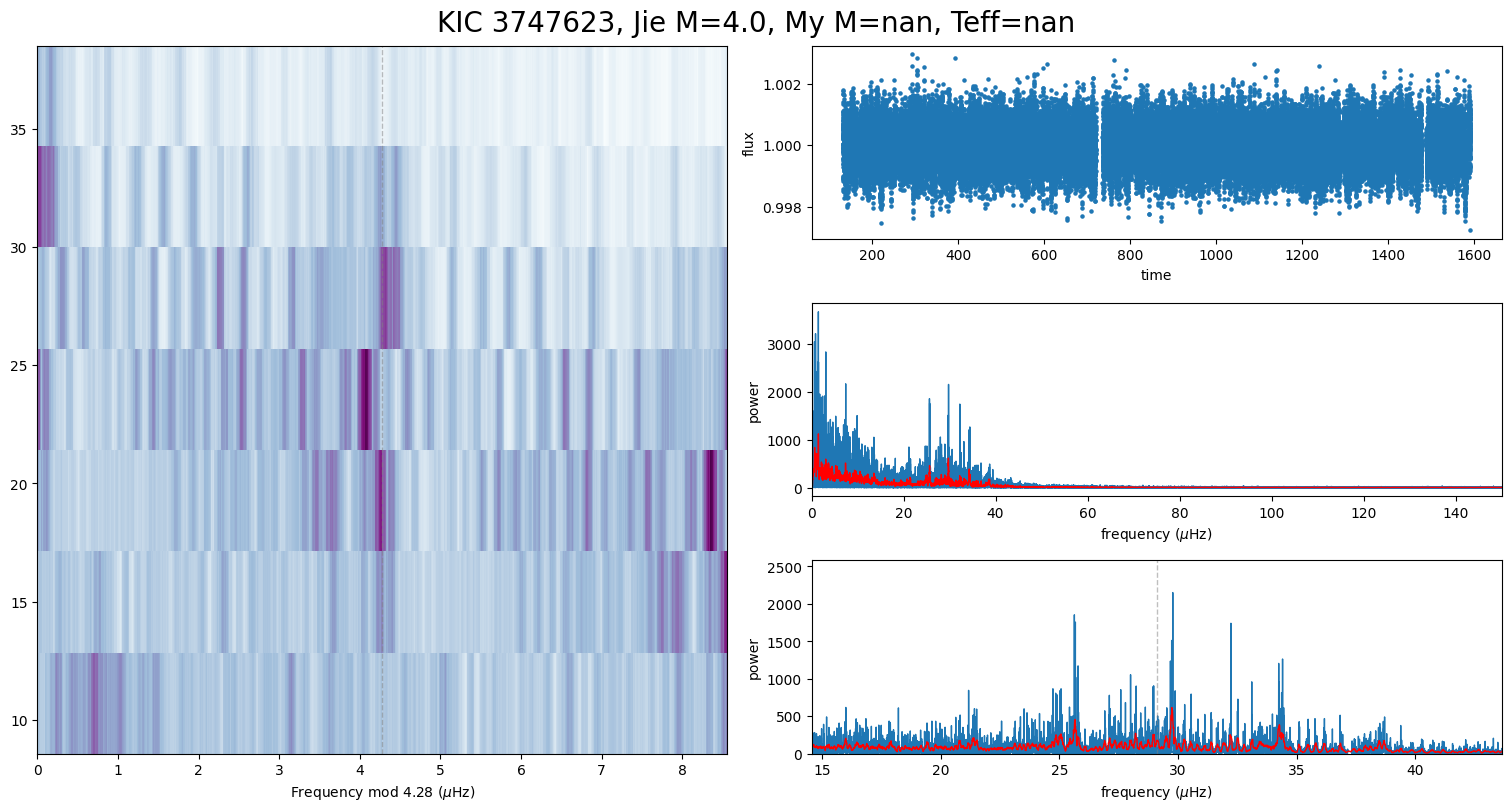

In [13]:
replicated_grid_plot('KIC 3747623',lightcurve['time'],lightcurve['flux'],
                     powerspec['freq'],powerspec['power'],save_output=False,
                     smooth_percent=0.02,newvals=True)

Question: do we peakbag on the smoothed or unsmoothed power spectra? I'm going to guess on the unsmoothed for now.

68


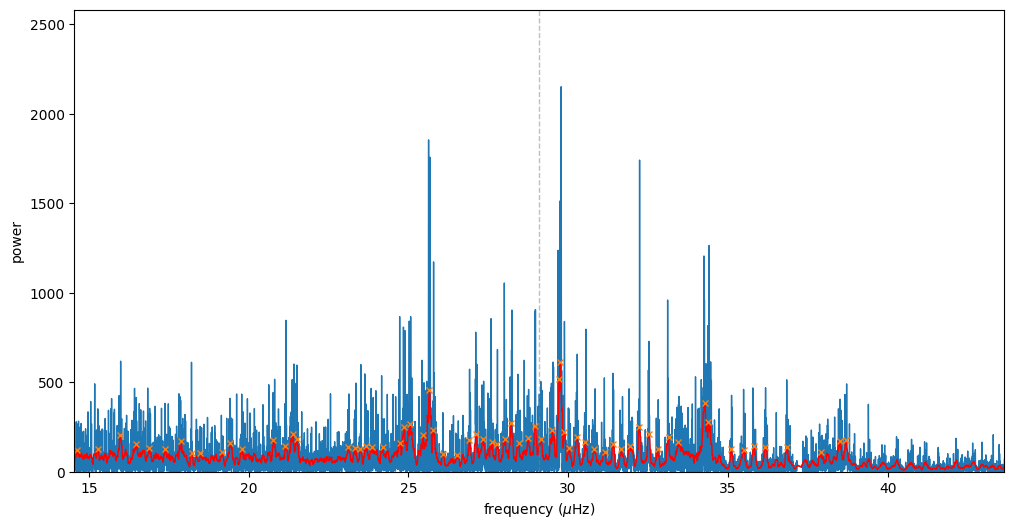

In [14]:
# attempt one is going to be just finding one of the l=0 peaks.
smooth_percent = 0.02

plt.figure(figsize=(12,6))
plt.plot(freq,power,linewidth=1)
freq_res = np.median(np.diff(freq))
plt.plot(freq,convolve(power, Box1DKernel((delta_nu*smooth_percent)/freq_res)),linewidth=1,color='r')
plt.axvline(nu_max,color='grey',linestyle='--',alpha=0.5)

smoothed_power = convolve(power, Box1DKernel((delta_nu*smooth_percent)/freq_res))
power_window = smoothed_power[(nu_max*0.5 < freq) & (freq < nu_max*1.5)]
# print(max(power_window))
# not sure there's a dynamically good way to define the prominence
peaks, properties = sp.signal.find_peaks(power_window,prominence=60) 

plt.plot(freq[(nu_max*0.5 < freq) & (freq < nu_max*1.5)][peaks], power_window[peaks], "x", markersize=5)
print(len(peaks))


subset = power[(nu_max*0.8 < freq) & (freq < nu_max*1.2)]
peak = max(subset)
plt.ylim(0,peak*1.2)
plt.xlim(nu_max*0.5,nu_max*1.5)
plt.xlabel(r'frequency ($\mu$Hz)')
plt.ylabel('power')
plt.show()

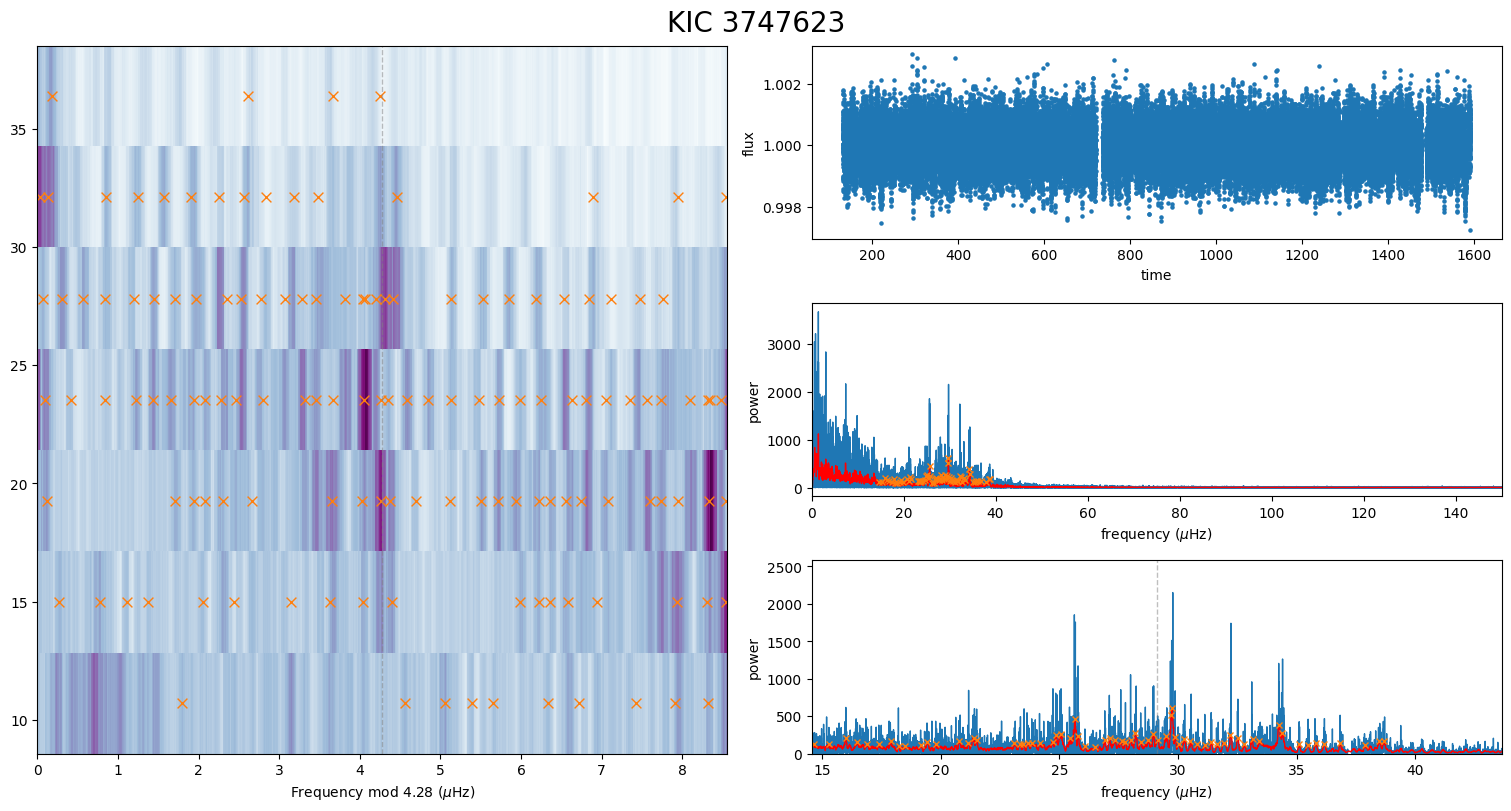

In [15]:
# going to need to make a new grid plot function that takes in a dictionary of frequency values and overplots them

star_name = 'KIC 3747623'

# if newvals == False:
#     delta_nu = highmass_rc['Delnu'][highmass_rc['KIC']==float(star_name[4:])].values[0]
#     nu_max = highmass_rc['numax'][highmass_rc['KIC']==float(star_name[4:])].values[0]
# #         mass = highmass_rc['ClcorM'][highmass_rc['KIC']==float(star_name[4:])].values[0]
# else:
#     delta_nu = highmass_rc_newvals['Delnu'][highmass_rc_newvals['KIC']==float(star_name[4:])].values[0]
#     nu_max = highmass_rc_newvals['numax'][highmass_rc_newvals['KIC']==float(star_name[4:])].values[0]
# #         mass = highmass_rc_newvals['ClcorM'][highmass_rc_newvals['KIC']==float(star_name[4:])].values[0]
# if smoothvals == True:
#     nu_max = highmass_rc_newvals['smooth_numax'][highmass_rc_newvals['KIC']==float(star_name[4:])].values[0]
mass = highmass_rc['ClcorM'][highmass_rc['KIC']==float(star_name[4:])].values[0]
time = np.asarray(time)
flux = np.asarray(flux)
freq = np.asarray(freq)
power = np.asarray(power)

fig = plt.figure(figsize=[15,8],constrained_layout=True)

gs = GridSpec(3, 2, figure=fig)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 1])
ax4 = fig.add_subplot(gs[2, 1])

freq_res = np.median(np.diff(freq))
#     power = convolve(power, Box1DKernel((delta_nu*0.03)/freq_res))
z, ext, echelle_x, echelle_y = yl_echelle(freq, 
                                        convolve(power, Box1DKernel((delta_nu*smooth_percent)/freq_res)),
                                        delta_nu, 
                                        fmin=nu_max*0.5, fmax=nu_max*1.5, echelletype="replicated",
                                        return_xy=True)
z = np.sqrt(z) #sqrt scaling
ax1.imshow(z, extent=ext, aspect='auto', interpolation='nearest', cmap='BuPu')

#### adding in the part for labeling the frequencies found before ####
xs = []
ys = []
for frequency in freq[(nu_max*0.5 < freq) & (freq < nu_max*1.5)][peaks]:
    x = (frequency - np.min(echelle_x)) % delta_nu
    y = echelle_y[echelle_y < frequency].max()# + slider_Dnu.val*5# + self.echelle_y[0]
    xs.append(x)
    ys.append(y)
ax1.scatter(xs, ys, s=50, marker='x', color='tab:orange')
ax1.scatter(xs+delta_nu, ys-delta_nu, s=50, marker='x', color='tab:orange')
# ax1.scatter(freq[(nu_max*0.5 < freq) & (freq < nu_max*1.5)][peaks], power_window[peaks], "x", markersize=5)
##############

#     echx, echy, echz = yl_echelle_older(freq,
#                                   convolve(power, Box1DKernel((delta_nu*smooth_percent)/freq_res)),
#                                   delta_nu,
#                                   fmin=nu_max*0.5,fmax=nu_max*1.5,echelletype="replicated")
#     echz = np.sqrt(echz)
#     levels = np.linspace(np.min(echz),np.max(echz),500)
#     ax1.contourf(echx,echy,echz,cmap='BuPu',levels=levels)
#     ax1.axis([np.min(echx),np.max(echx),np.min(echy),np.max(echy)])
ax1.axis(ext)
ax1.set_xlabel("Frequency mod "+str("{0:.2f}").format(delta_nu) + " ($\mu$Hz)")
ax1.axvline(delta_nu,color='grey',linestyle='--',alpha=0.5)

#     echelle.plot_echelle(freq, power, delta_nu, scale='sqrt', smooth=True, ax=ax1,
#                         fmin=nu_max*0.5,fmax=nu_max*1.5,smooth_filter_width=(delta_nu*0.03)/freq_res)

ax2.scatter(time,flux,s=5)
ax2.set_xlabel('time')
ax2.set_ylabel('flux')

ax3.plot(freq,power,linewidth=1)
ax3.plot(freq,convolve(power, Box1DKernel((delta_nu*smooth_percent)/freq_res)),linewidth=1,color='r')
ax3.plot(freq[(nu_max*0.5 < freq) & (freq < nu_max*1.5)][peaks], power_window[peaks], "x", markersize=5)
# ax3.set_ylim(0,500)
ax3.set_xlim(0,150)
ax3.set_xlabel(r'frequency ($\mu$Hz)')
ax3.set_ylabel('power')


ax4.plot(freq,power,linewidth=1)
ax4.plot(freq,convolve(power, Box1DKernel((delta_nu*smooth_percent)/freq_res)),linewidth=1,color='r')
ax4.plot(freq[(nu_max*0.5 < freq) & (freq < nu_max*1.5)][peaks], power_window[peaks], "x", markersize=5)
ax4.axvline(nu_max,color='grey',linestyle='--',alpha=0.5)
subset = power[(nu_max*0.8 < freq) & (freq < nu_max*1.2)]
peak = max(subset)
ax4.set_ylim(0,peak*1.2)
#     ax4.set_ylim(0,600)
ax4.set_xlim(nu_max*0.5,nu_max*1.5)
ax4.set_xlabel(r'frequency ($\mu$Hz)')
ax4.set_ylabel('power')

# new_mass = round(adjusted_masses['a_corr_mass'][adjusted_masses['KIC']==int(star_name[4:])].values[0],2)
# teff = highmass_rc_newvals['a_Teff'][highmass_rc_newvals['KIC']==int(star_name[4:])].values[0]
#     print(new_mass)
#     print(teff)
fig.suptitle(star_name,fontsize=20)
# if save_output == True:
# plt.savefig('../KIC'+star_name[4:]+'_findpeaks')
plt.show()

# Yaguang's peakbagging technique

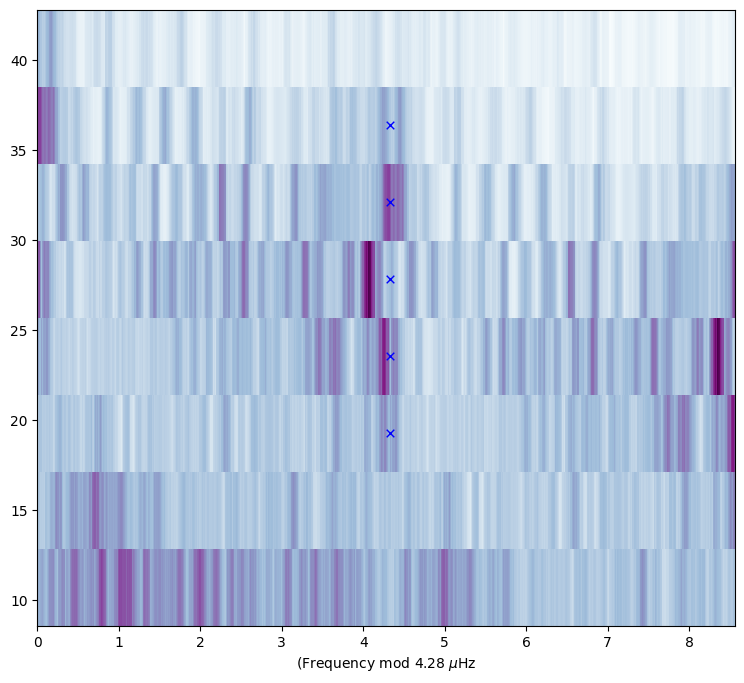

In [18]:
fig = plt.figure(figsize=(9,8))
ax1 = fig.add_subplot(111)
z, ext = yl_echelle(freq, 
                    convolve(power, Box1DKernel((delta_nu*smooth_percent)/freq_res)),
                    delta_nu, 
                    nu_max-4.0*delta_nu,
                    nu_max+4.0*delta_nu,
                    echelletype="replicated",
                    offset=0.)
# levels = np.linspace(np.min(echz),np.max(echz),500)
# ax1.contourf(echx,echy,echz,cmap="gray_r",levels=levels)
z = np.sqrt(z) #sqrt scaling
ax1.imshow(z, extent=ext, aspect='auto', interpolation='nearest', cmap='BuPu')
ax1.axis(ext)
# ax1.axis([np.min(echx),np.max(echx),np.min(echy),np.max(echy)])

ax1.set_xlabel("(Frequency mod {:0.2f} $\mu$Hz".format(delta_nu))

ns = np.arange(0, 5)+5
eps = 0.01
delta_nu02 = 5.
delta_nu01 = 4
fc0 = delta_nu*(ns+eps)
fc2 = fc0 - delta_nu02
fc1 = fc0 + delta_nu/2. - delta_nu01

# ax1.scatter(fc0%delta_nu, fc0-fc0%delta_nu+0.5*delta_nu, marker='x', color='b',s=30)
# ax1.scatter(fc2%delta_nu, fc2-fc2%delta_nu+0.5*delta_nu, marker='x', color='g',s=30)
# ax1.scatter(fc1%delta_nu, fc1-fc1%delta_nu+0.5*delta_nu, marker='x', color='r',s=30)
ax1.scatter(fc0%delta_nu+delta_nu, fc0-fc0%delta_nu+0.5*delta_nu-delta_nu, marker='x', color='b',s=30)
# ax1.scatter(fc2%delta_nu+delta_nu, fc2-fc2%delta_nu+0.5*delta_nu-delta_nu, marker='x', color='g',s=30)
# ax1.scatter(fc1%delta_nu+delta_nu, fc1-fc1%delta_nu+0.5*delta_nu-delta_nu, marker='x', color='r',s=30)
plt.show()

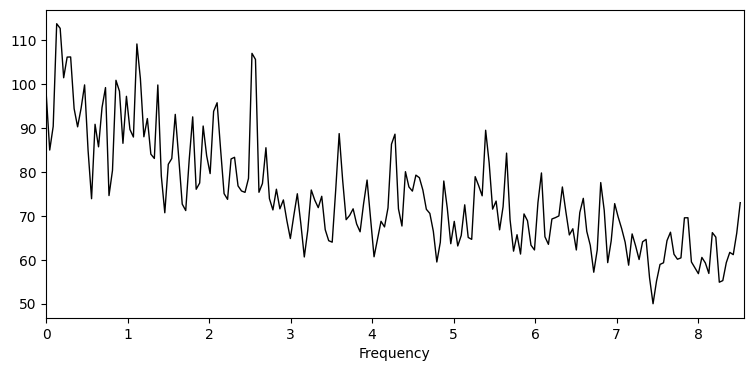

In [17]:
## Collapsed Echelle ##

## this doesn't work because I'm not taking only the oscillation region
## then also this being overwhelmed by the granulation I'm sure

freqc = np.arange(0, delta_nu*2, delta_nu/100)
powerc = np.zeros(len(freqc))
fmin = 10*delta_nu
for i in range(11):
    powerc += np.interp(fmin+i*delta_nu+freqc, freq[freq<70], 
                    convolve(power[freq<70], Box1DKernel((delta_nu*smooth_percent)/freq_res)))


fig = plt.figure(figsize=(9,4))
ax1 = fig.add_subplot(111)
ax1.plot(freqc, powerc, 'k')
ax1.set_xlim(0, 2*delta_nu)
ax1.set_xlabel("Frequency")

ax1.axvline(29, color='b', label='l=0')
ax1.axvline(29+delta_nu, color='b', label='l=0')

ax1.axvline(29+delta_nu/2.-5, color='r', label='l=1')
ax1.axvline(29+delta_nu/2.+delta_nu-5, color='r', label='l=1')

ax1.axvline(29-4, color='g', label='Possibly l=2')
ax1.axvline(29+delta_nu-4, color='g', label='Possibly l=2')
plt.show()

In [20]:
import pymc

In [31]:
idx = (freq > nu_max-2.0*delta_nu) & (freq < nu_max+2.0*delta_nu)
x = freq[idx]
y = power[idx]


with pymc.Model() as model:  # model specifications in PyMC are wrapped in a with-statement
    # hyper-parameters (priors)
    
#     delta_nu_g, nu_max_g = 89.5, 1850 #mean of the prior of the delta nu and nu max
    e_delta_nu_g, e_nu_max_g = 0.2, 5 #std dev fo the prior of the delta nu and nu max
    
    Nmode = 5
    ns = np.arange(0, 5)+5
    
    #prior on delta nu
    delta_nu_prior = pymc.TruncatedNormal('delta_nu', mu=delta_nu, sigma=e_delta_nu_g, 
                                    lower=delta_nu-2*e_delta_nu_g, upper=delta_nu+2*e_delta_nu_g, 
                                    shape=1) 
    #epsilon prior
    eps_prior = pymc.Uniform('eps', lower=eps-0.2, upper=eps+0.2, shape=1)
    # alpha = pymc.HalfCauchy('alpha', beta=0.1, shape=1)
    # delta_nu02 = pymc.TruncatedNormal('delta_nu02', mu=10., sigma=0.02*delta_nu_g, lower=0., upper=0.5*delta_nu_g, shape=1)
#     delta_nu01 = pymc.TruncatedNormal('delta_nu01', mu=10./3., sigma=0.02*delta_nu_g, 
#                                       lower=0., upper=0.5*delta_nu_g, shape=1)
    
    #initial guess for the background
    #shouldn't this be frequency dependent (a line with slope)
    bg = pymc.Uniform('bg', lower=0., upper=5, shape=1)
    
    # initial guess for amplitude and width of lines
    A = pymc.Normal('A', mu=4, sigma=2, shape=1)
    w = pymc.Normal('w', mu=np.e**(0.9638*np.log(nu_max)-1.7145), sigma=delta_nu*2, shape=1)

    # lw_a = pymc.Uniform('lw_a', lower=0, upper=10, shape=1)
    # lw_Ga = pymc.Uniform('lw_Ga', lower=0, upper=100, shape=1)
    
    fc0 = pymc.Normal('fc0', mu=delta_nu_prior*(ns+eps_prior), sigma=3.0, shape=Nmode) 
    # fc2 = pymc.Normal('fc2', mu=delta_nu*(ns+eps)-delta_nu02, sigma=delta_nu*0.02, shape=Nmode) 
#     fc1 = pymc.Normal('fc1', mu=delta_nu*(ns+eps+0.5)-delta_nu01, sigma=3.0, shape=Nmode) 
    
    amp0 = pymc.Normal('amp0', mu=A*np.e**(-(fc0-nu_max)**2.0/(2*w**2.0)), 
                       sigma=0.5*A*np.e**(-(fc0-nu_max)**2.0/(2*w**2.0)), shape=Nmode)
    # amp2 = pymc.Normal('amp2', mu=A*np.e**(-(fc2-nu_max_g)**2.0/(2*w**2.0))*0.6, sigma=0.1*A*np.e**(-(fc2-nu_max_g)**2.0/(2*w**2.0))*0.6, shape=Nmode)
#     amp1 = pymc.Normal('amp1', mu=A*np.e**(-(fc1-nu_max_g)**2.0/(2*w**2.0))*1.3, 
#                        sigma=0.5*A*np.e**(-(fc1-nu_max_g)**2.0/(2*w**2.0))*1.3, shape=Nmode)
    
    lw0 = pymc.HalfNormal('lw0', sigma=0.2, shape=Nmode)
    # lw2 = pymc.HalfNormal('lw2', sigma=1, shape=Nmode)
#     lw1 = pymc.HalfNormal('lw1', sigma=2, shape=Nmode)
    
    # parameters (priors)
    power_model = 0 
    for imode in range(Nmode):
        power_model += (2*amp0[imode]**2.0/(np.pi*lw0[imode]))/(1+(x-fc0[imode])**2.0/lw0[imode]**2.0)
        # power_model += (2*amp2[imode]**2.0/(np.pi*lw2[imode]))/(1+(x-fc2[imode])**2.0/lw2[imode]**2.0)
#         power_model += (2*amp1[imode]**2.0/(np.pi*lw1[imode]))/(1+(x-fc1[imode])**2.0/lw1[imode]**2.0)
    power_model += bg
    
    # model match observation (likelihood)
    # had to use some funky gamma function to do this properly over the chisq (with 2 degrees of freedom) whatever thing
    likelihood = pymc.Gamma('likelihood', alpha=1., beta=1./power_model, observed=y)
    
    # inference, draw 3000 posterior samples using NUTS sampling
    idata = pymc.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [delta_nu, eps, bg, A, w, fc0, amp0, lw0]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 234 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.


In [32]:
import arviz as az
az.to_netcdf(idata, 'samples.netcdf')

'samples.netcdf'

In [33]:
idata = az.from_netcdf('samples.netcdf')

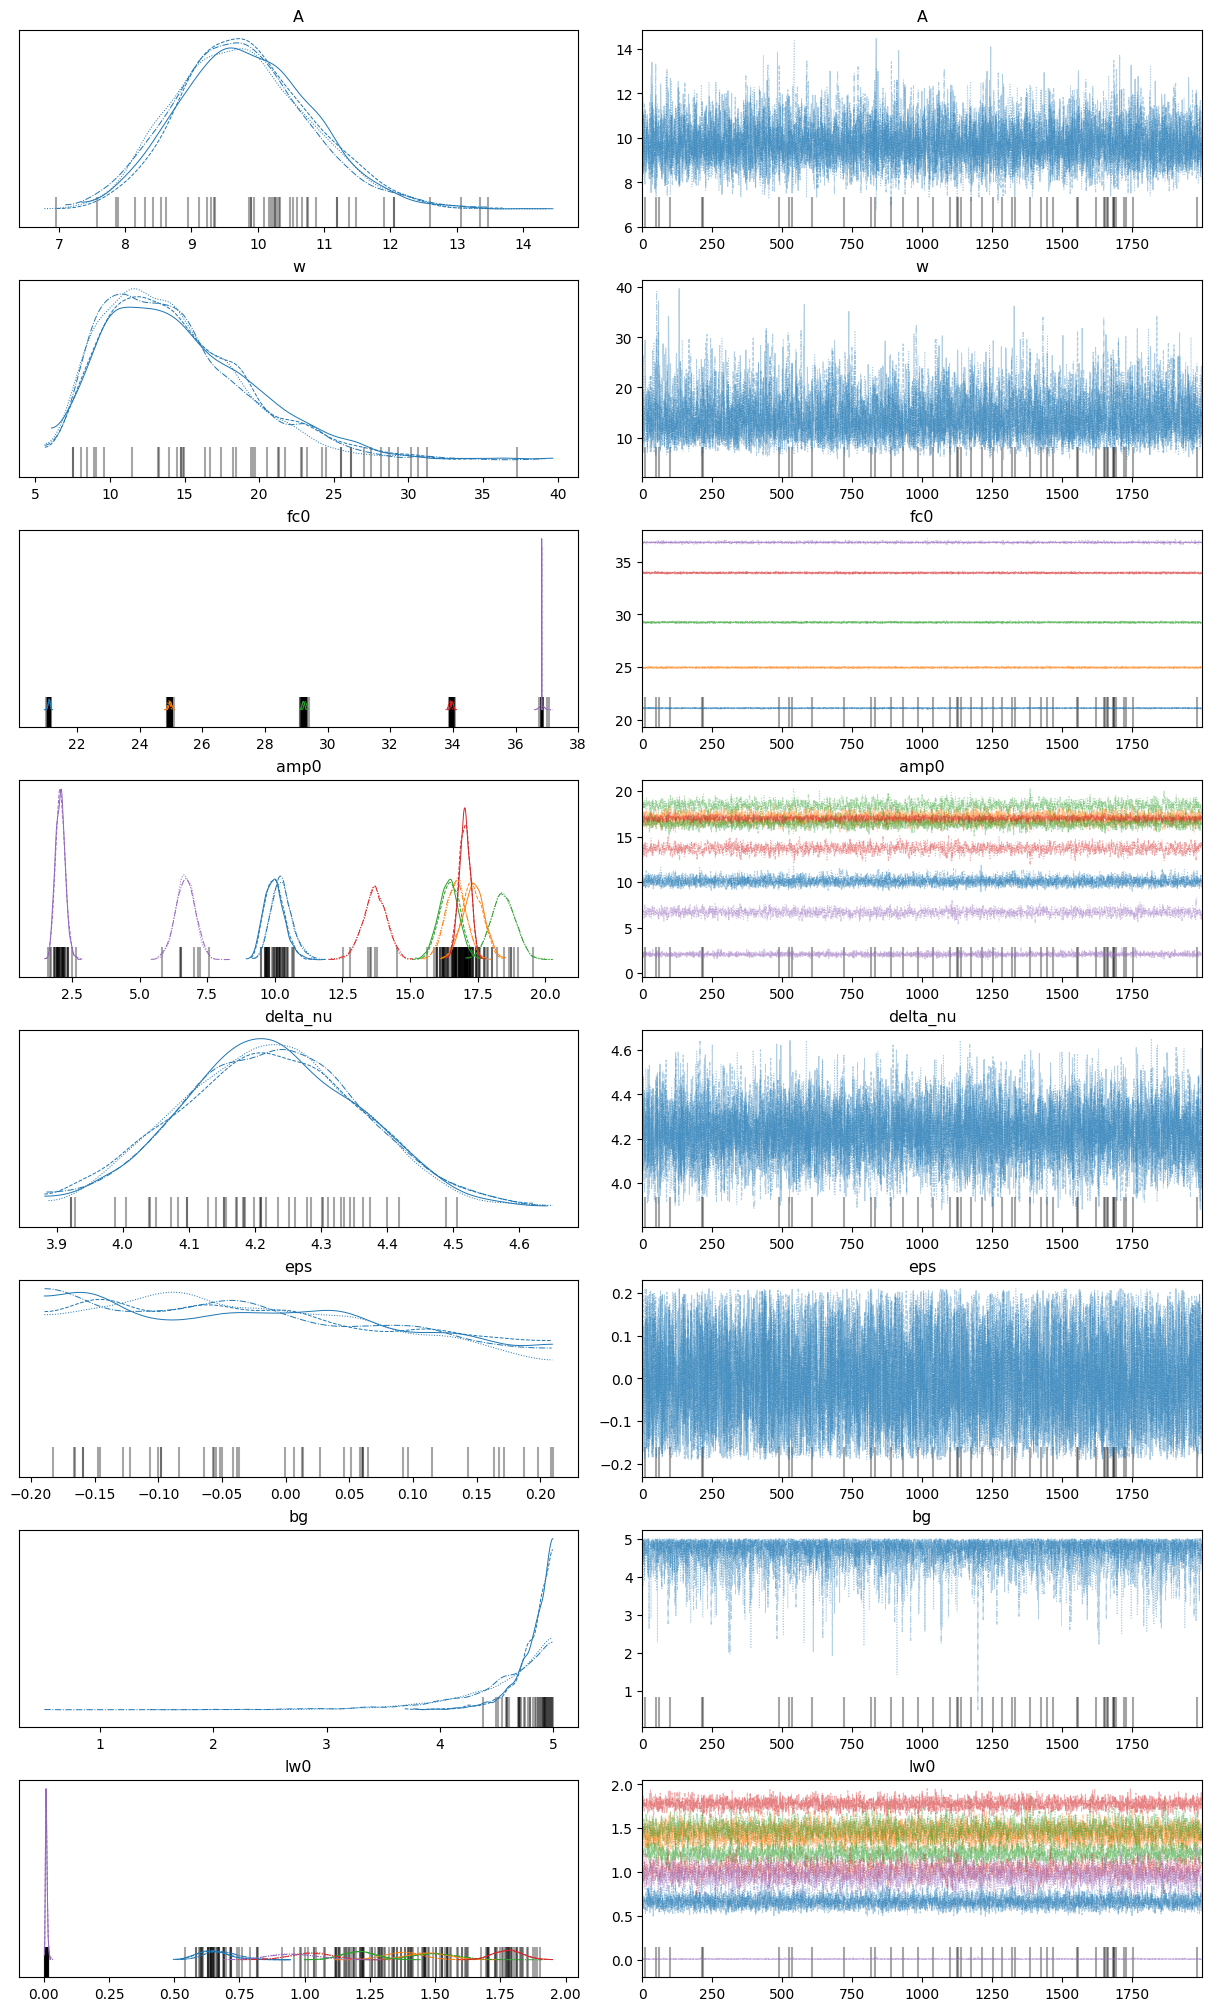

In [34]:
az.plot_trace(idata, figsize=(12, 20), backend_kwargs={'constrained_layout':True})
# az.plot_posterior(idata)
params = az.summary(idata, stat_focus="median")
paramsMedian = params['median']
paramsErr = params['mad']

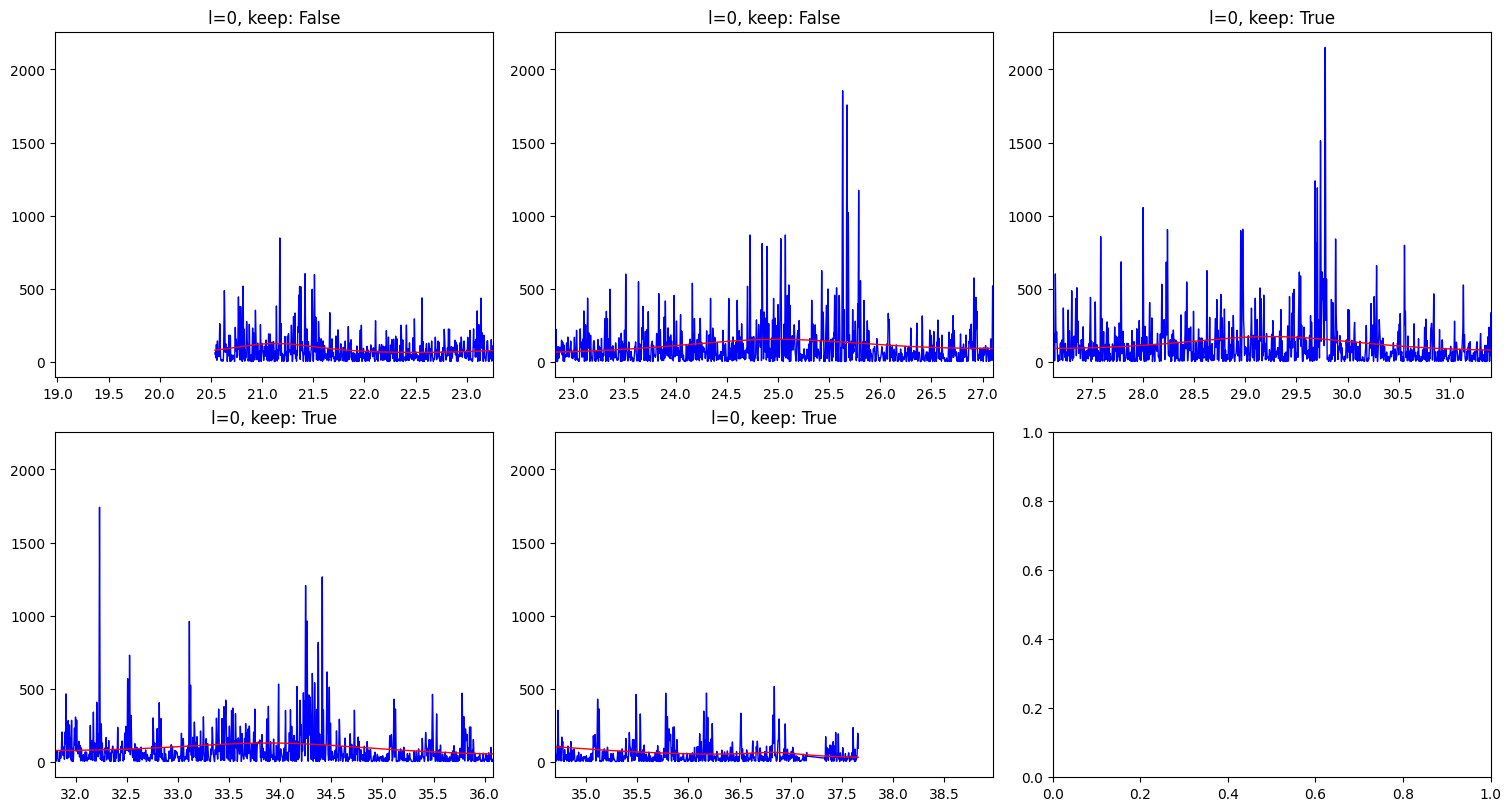

In [35]:
idx = (freq > nu_max-2.0*delta_nu) & (freq < nu_max+2.0*delta_nu)
x = freq[idx]
y = power[idx]
    
Nmode = 5
# yfit = paramsMedian['H']/(1+(x-paramsMedian['fc'])**2.0/paramsMedian['lw']**2.0) + 1

yfit = paramsMedian['bg[0]']
for imode in range(Nmode):
    # power_model += (2*amp0[imode]**2.0/(np.pi*lw0[imode]))/(1+(x-fc0[imode])**2.0/lw**2.0)
    yfit += (2*paramsMedian[f'amp0[{imode}]']**2.0/(np.pi*paramsMedian[f'lw0[{imode}]']))/(1+(x-paramsMedian[f'fc0[{imode}]'])**2.0/paramsMedian[f'lw0[{imode}]']**2.0)
#     yfit += (2*paramsMedian[f'amp1[{imode}]']**2.0/(np.pi*paramsMedian[f'lw1[{imode}]']))/(1+(x-paramsMedian[f'fc1[{imode}]'])**2.0/paramsMedian[f'lw1[{imode}]']**2.0)
    # yfit += (2*paramsMedian[f'amp2[{imode}]']**2.0/(np.pi*paramsMedian[f'lw2[{imode}]']))/(1+(x-paramsMedian[f'fc2[{imode}]'])**2.0/paramsMedian[f'lw2[{imode}]']**2.0)

ncols, nrows = 3, 2
fig, axes = plt.subplots(figsize=(5*ncols, 4*nrows), nrows=nrows, ncols=ncols, constrained_layout=True)
axes = axes.reshape(-1)
for iax, ax in enumerate(axes[:5]):
    ax.plot(x, y, 'b-', label="sampled data")
    ax.plot(x, yfit, 'r-', label="fitted data")
    ax.set_xlim(paramsMedian[f'fc0[{iax}]']-0.5*delta_nu, paramsMedian[f'fc0[{iax}]']+0.5*delta_nu)
    idx = (x>(paramsMedian[f'fc0[{iax}]']-0.5*delta_nu)) & (x<(paramsMedian[f'fc0[{iax}]']+0.5*delta_nu))
#     ax.set_ylim(0., 20)
    keep = False if iax in [0,1] else True
    ax.set_title('l=0, keep: {}'.format(keep))
# plt.legend(loc=0);

# plt.savefig('plot_l0_fits.jpg')

# Yifan's peaknoting tool

In [13]:
from EchellePlotter import EchellePlotter

In [14]:
%matplotlib notebook

using 0-2 on the keyboard switches l mode label tool, and r changes to remove points tool, and Esc changes to no tools
Also h and l change the period echelle

In [28]:
# EchellePlotter?

<IPython.core.display.Javascript object>


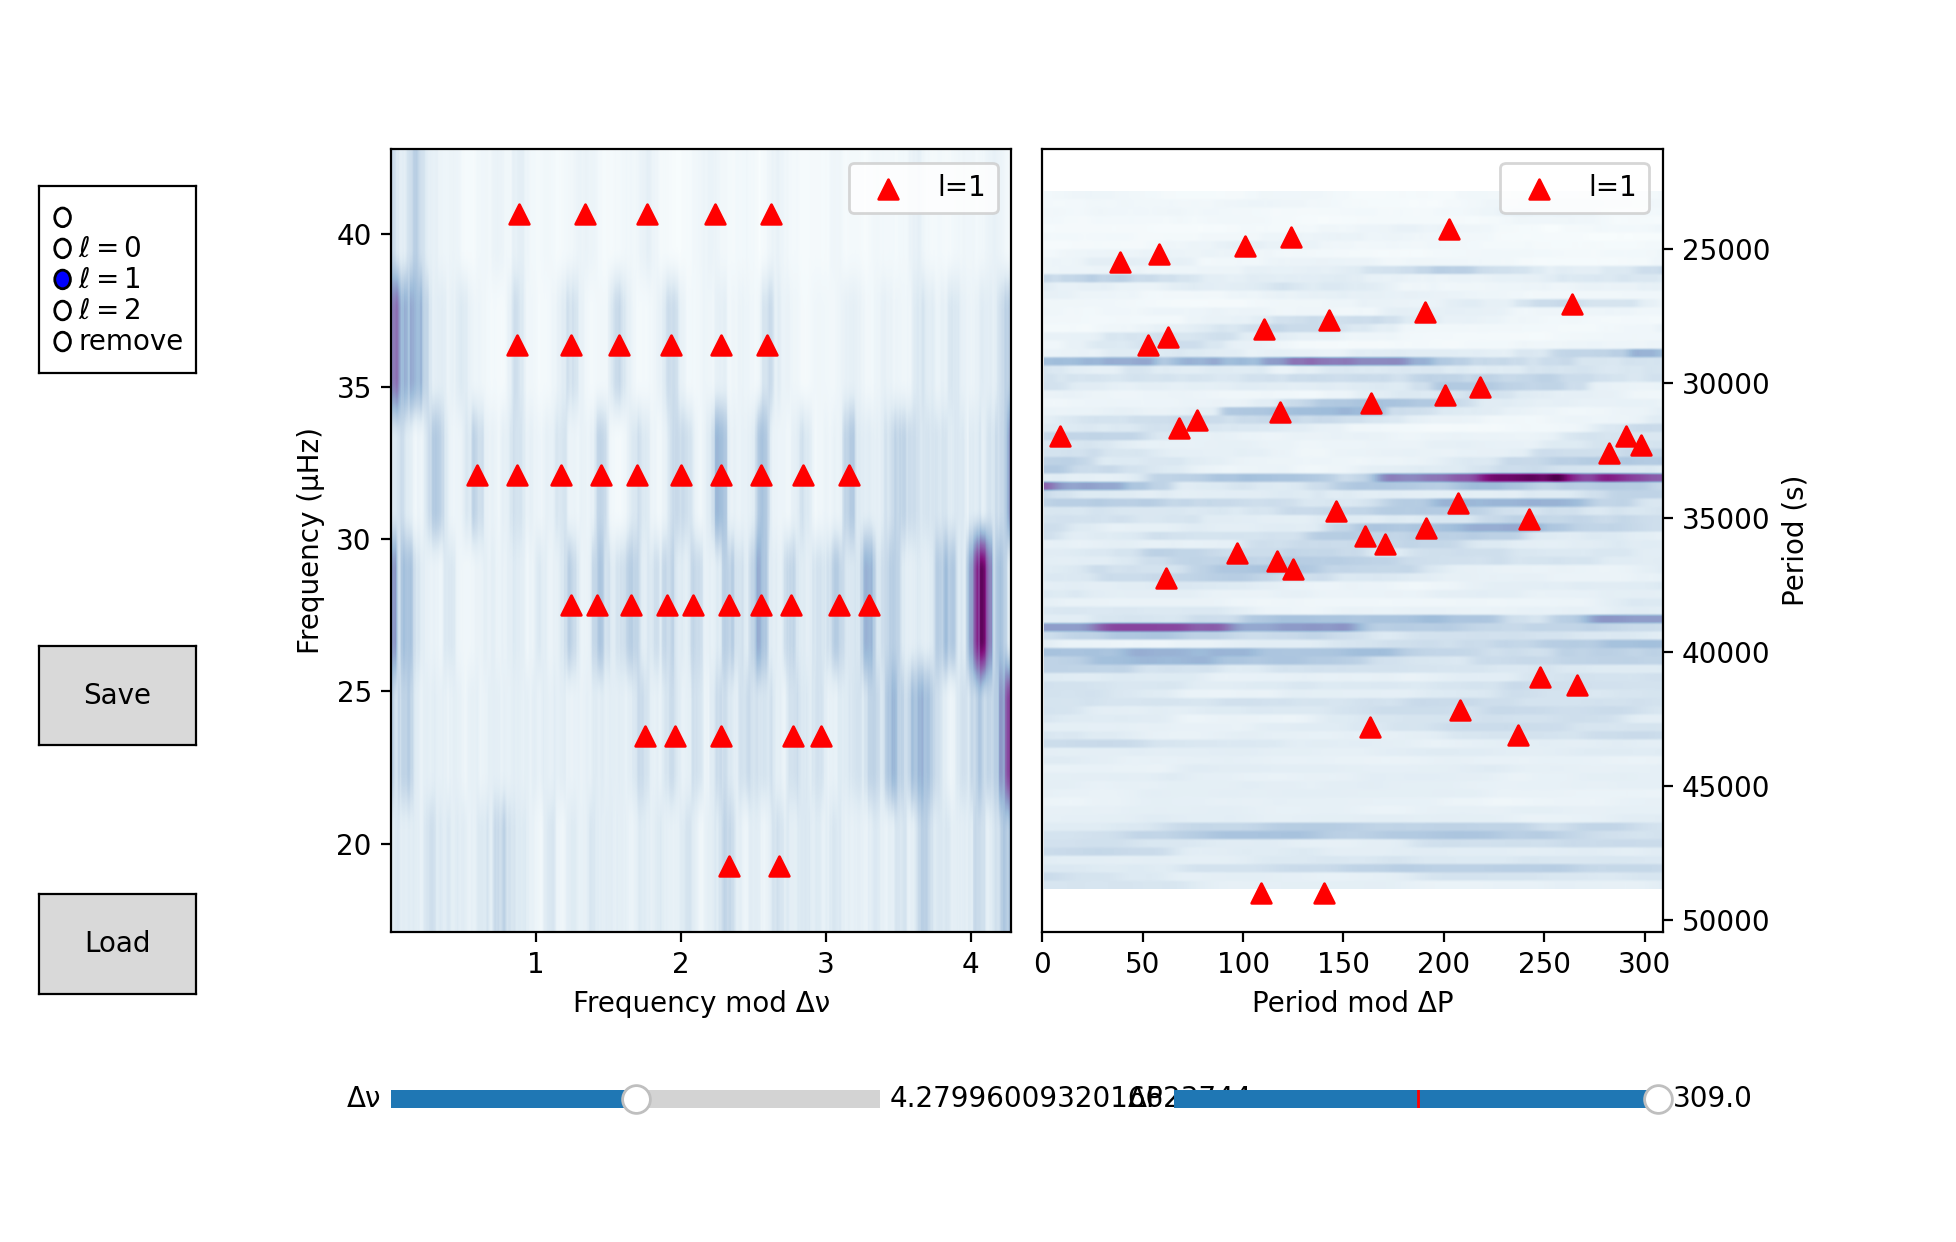

In [111]:
# freq,convolve(power, Box1DKernel((delta_nu*smooth_percent)/freq_res))

EchellePlotter(freq,smoothed_power,delta_nu-0.05,delta_nu+0.05,fmin=nu_max*0.7,fmax=nu_max*1.5,
               plot_period=True,DP_min=200,DP_max=310,pstep=0.5)

In [15]:
from StretchedEchellePlotter import StretchedEchellePlotter

<IPython.core.display.Javascript object>


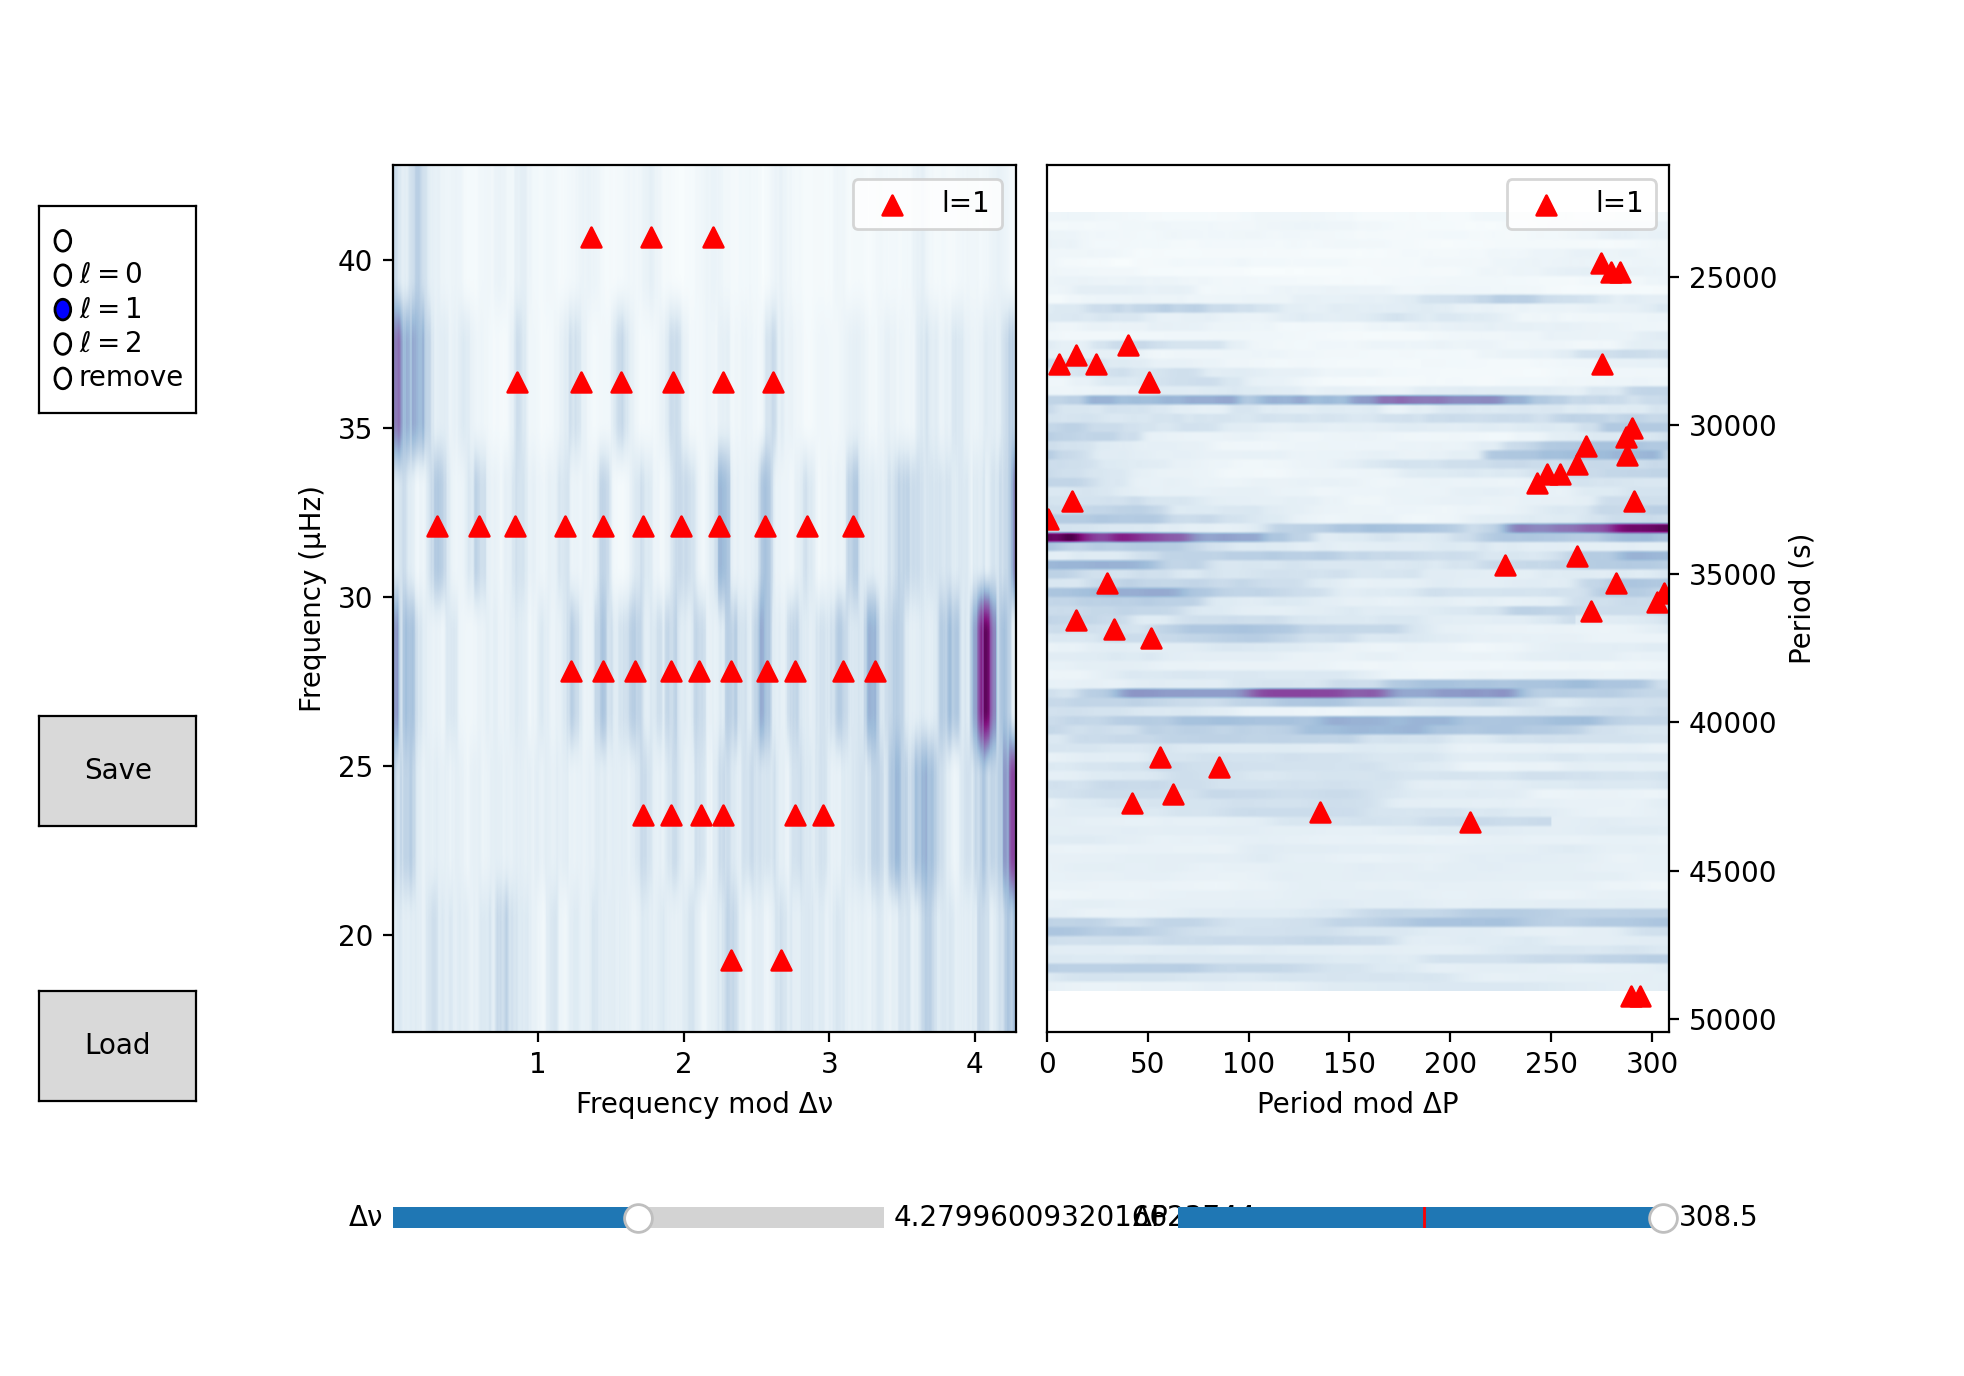

In [16]:
StretchedEchellePlotter(freq,smoothed_power,delta_nu-0.05,delta_nu+0.05,fmin=nu_max*0.7,fmax=nu_max*1.5,
                       plot_period=True,DP_min=200,DP_max=310,pstep=0.5)

# Stretched Echelle

In [89]:
def stretched_echelle(d01, DPi1, q):

    Theta_p = np.pi * (nu/delta_nu-1/2-eps_p-d01)
        
    tau = 1/(nu*1e-6) + DPi1/np.pi * np.arctan(q / np.tan(Theta_p)) #from Joel Ong recent arxiv paper

    plt.figure(figsize=[5,6])
    echx, echy, echz = yl_echelle(tau[::-1], ps[::-1]**0.5, period=DPi1, echelletype='replicated')
    levels = np.linspace(np.min(echz),np.max(echz),300)
    plt.contourf(echx,echy,echz,cmap="BuPu",levels=levels)
    # plt.axis(np.min(echx),np.max(echx))
    plt.ylim(np.min(tau),np.max(tau))
    plt.xlim(0, 2*DPi1)
    plt.axvline(DPi1, linestyle='--', c='k')
    plt.xlabel(r'$\tau$ mod $\Delta\Pi_1$ (s)')
    plt.ylabel(r'$\tau$ (s)')
    plt.show()

In [77]:
from ipywidgets import interactive

In [85]:
%matplotlib inline

In [93]:
eps_p = 0.9
nu = np.linspace(22, 40, 5000) #adjust the plotting range
ps = np.interp(nu, freq, smoothed_power)

# block l=0 and l=2 modes
f0 = int(np.min(nu)/delta_nu)*delta_nu + (eps_p + 0)*delta_nu
while f0 < np.max(nu):
    idx = ((nu-f0) < 0.05*delta_nu) & ((nu-f0) > -0.25*delta_nu) 
#     ps[idx] = 0.
    f0 = f0+delta_nu

    
interactive_plot = interactive(
    stretched_echelle, 
    d01=(-0.5, 0.5, 0.001), 
    DPi1=(180, 350, 0.1), 
    q=(0.001, 1, 0.01)
)

# delta_nu=(13, 15, 0.001), 

# d01 = 0
# DPi1 = 308.8
# q = 0.59

output = interactive_plot.children[-1]
output.layout.height = '580px'
interactive_plot

interactive(children=(FloatSlider(value=0.0, description='d01', max=0.5, min=-0.5, step=0.001), FloatSlider(va…

In [23]:
delta_nu,nu_max,mass,lightcurve,powerspec = read_star('KIC 3758458',suppress_output=False)
delta_nu,nu_max,mass,time,flux,freq,power,amp = read_star('KIC 3758458',unpack=True,suppress_output=False)

KIC 3758458
Using new values
delta_nu = 5.836
nu_max = 74.21
mass = 3.7
returning dataframes
KIC 3758458
Using new values
delta_nu = 5.836
nu_max = 74.21
mass = 3.7
unpacking data frames


In [24]:
freq_res = np.median(np.diff(freq))
smoothed_power = convolve(power, Box1DKernel((delta_nu*smooth_percent)/freq_res))

In [103]:
freq_res = np.median(np.diff(freq))
smoothed_power = convolve(power, Box1DKernel((delta_nu*smooth_percent)/freq_res))

eps_p = 0.9
# nu = np.linspace(50, 100, 5000)
nu = np.linspace(nu_max-4*delta_nu, nu_max+4*delta_nu, 5000) #adjust the plotting range
ps = np.interp(nu, freq, smoothed_power)

# block l=0 and l=2 modes
f0 = int(np.min(nu)/delta_nu)*delta_nu + (eps_p + 0)*delta_nu
while f0 < np.max(nu):
    idx = ((nu-f0) < 0.05*delta_nu) & ((nu-f0) > -0.25*delta_nu) 
#     ps[idx] = 0.
    f0 = f0+delta_nu

    
interactive_plot = interactive(
    stretched_echelle, 
    d01=(-0.5, 0.5, 0.001), 
    DPi1=(180, 350, 0.1), 
    q=(0.001, 1, 0.01)
)

# Dnu=(13, 15, 0.001), 

# d01 = 0
# DPi1 = 264.7
# q = 0.29

output = interactive_plot.children[-1]
output.layout.height = '580px'
interactive_plot

interactive(children=(FloatSlider(value=0.0, description='d01', max=0.5, min=-0.5, step=0.001), FloatSlider(va…

# more stuff

In [58]:
%matplotlib widget

# import numpy as np
# import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button

def echelle(x, y, period, fmin=None, fmax=None, echelletype="single", offset=0.0):
    '''
    Make an echelle plot used in asteroseismology.
    
    Input parameters
    ----
    x: 1d array-like, freq
    y: 1d array-like, power spectrum
    period: float, length of each vertical stack (Dnu in a frequency echelle, DPi in a period echelle)
    fmin: float, minimum frequency to be plotted
    fmax: float, maximum frequency to be plotted
    echelletype: str, `single` or `replicated`
    offset: float, an amount by which the diagram is shifted horizontally
    
    Return
    ----
    z: a 2d numpy.array, folded power spectrum
    extent: a list, edges (left, right, bottom, top) 
    
    Users can create an echelle diagram with the following command:
    ----
    
    import matplotlib.pyplot as plt
    z, ext = echelle(freq, power, Dnu, fmin=numax-4*Dnu, fmax=numax+4*Dnu)
    plt.imshow(z, extent=ext, aspect='auto', interpolation='nearest')
    
    '''
    
    if fmin is None: fmin=0.
    if fmax is None: fmax=np.nanmax(x)

    fmin = fmin - offset
    fmax = fmax - offset
    x = x - offset

    fmin = 0.0 if fmin<0. else fmin - (fmin % period)

    # define plotting elements
    resolution = np.median(np.diff(x))
    # number of vertical stacks
    n_stack = int((fmax-fmin)/period) 
    # number of point per stack
    n_element = int(period/resolution) 

    fstart = fmin - (fmin % period)
    
    z = np.zeros([n_stack, n_element])
    base = np.linspace(0, period, n_element) if echelletype=='single' else np.linspace(0, 2*period, n_element)
    for istack in range(n_stack):
        z[-istack-1,:] = np.interp(fmin+istack*period+base, x, y)
    
    extent = (0, period, fstart, fstart+n_stack*period) if echelletype=='single' else (0, 2*period, fstart, fstart+n_stack*period)
        
    return z, extent

class Star():
    def __init__(self, nu, ps, numax, Dnu, fmin=None, fmax=None, cmap='gray_r'):
        '''
        Make interactive frequency and strectched period echelle plots. Useful for finding Dnu and DPi1.
 
        Input parameters
        ----
        nu: 1d array-like, freq
        ps: 1d array-like, power spectrum
        numax: float, frequency of maximum power
        Dnu: float, p-mode large separation (approximate value is fine)
        fmin: float, minimum frequency to be plotted
        fmax: float, maximum frequency to be plotted
        cmap: str, colormap passed to matplotlib.pyplot.ax.imshow

        Users can create an interactive plot with the following command:
        ----

        %matplotlib widget

        # initiate a star object
        star = Star(nu, ps, numax, Dnu)

        # interactive echelles
        star.plot_freq_echelle()
        
        '''
        # trim data
        fmin = numax-4*Dnu if fmin is None else fmin
        fmax = numax+4*Dnu if fmax is None else fmax
        trim = (nu > fmin) & (nu < fmax)
        self.nu = nu[trim]
        self.ps = ps[trim]
        self.numax = numax
        self.Dnu = Dnu
        
        # initialize slider values
        self.Dnu_init = self.Dnu
        self.eps_p_init = 0.5
        self.d02_init = 0.15
        self.d01_init = 0.
        self.DPi1_init = 250
        self.q_init = 0.5
        # get radial orders
        self.ns = np.unique(np.array(self.nu/self.Dnu, dtype=int))[1:-1]

        Theta_p = np.pi * (self.nu/self.Dnu_init- (1/2+self.eps_p_init+self.d01_init) ) 
        self.tau = 1/(self.nu*1e-6) + self.DPi1_init/np.pi * np.arctan(self.q_init / np.tan(Theta_p))
        
        # passed to echelle api
        self.freq_echelle_kwargs = {'fmin':np.min(self.nu), 'fmax':np.max(self.nu), 'echelletype': 'replicated'}
        self.period_echelle_kwargs = {'fmin':np.min(self.tau), 'fmax':np.max(self.tau), 'echelletype': 'replicated'}
        
        # passes to matplotlib api
        self.cmap = cmap
        
    def plot_freq_echelle(self):
        
        fig = plt.figure(figsize=(10,6))

        xpos, xoff = 0.16, 0.45
        ypos, yoff = 0.95, 0.04
        width = 0.33
        
        # Make a horizontal slider to control Dnu.
        slider_Dnu = Slider(
            ax=fig.add_axes([xpos, ypos, width, 0.03]),
            label='Dnu',
            valmin=self.Dnu*0.9,
            valmax=self.Dnu*1.1,
            valinit=self.Dnu_init,
            valstep=self.Dnu*0.002,
        )
        
        # Make a horizontal slider to control eps_p.
        slider_eps_p = Slider(
            ax=fig.add_axes([xpos, ypos-yoff, width, 0.03]),
            label='eps_p',
            valmin=0.0,
            valmax=1.0,
            valinit=self.eps_p_init,
            valstep=0.01,
        )
        
        # Make a horizontal slider to control d02.
        slider_d02 = Slider(
            ax=fig.add_axes([xpos, ypos-yoff*2, width, 0.03]),
            label='d02',
            valmin=0.0,
            valmax=0.3,
            valinit=self.d02_init,
            valstep=0.005,
        )
        
        # Make a horizontal slider to control d01.
        slider_d01 = Slider(
            ax=fig.add_axes([xpos+xoff, ypos, width, 0.03]),
            label='d01',
            valmin=-0.5,
            valmax=0.5,
            valinit=self.d01_init,
            valstep=0.01,
        )
        
        # Make a horizontal slider to control DPi1.
        slider_DPi1 = Slider(
            ax=fig.add_axes([xpos+xoff, ypos-yoff, width, 0.03]),
            label='DPi1',
            valmin=30,
            valmax=400,
            valinit=self.DPi1_init,
            valstep=0.5,
        )
        
        # Make a horizontal slider to control q.
        slider_q = Slider(
            ax=fig.add_axes([xpos+xoff, ypos-yoff*2, width, 0.03]),
            label='q',
            valmin=0.0,
            valmax=1.0,
            valinit=self.q_init,
            valstep=0.01,
        )

        
        # create two axes
        axes = [fig.add_axes([xpos, 0.1, width, 0.7]), fig.add_axes([xpos+xoff, 0.1, width, 0.7]) ]
        
        # fig 1: frequency echelle diagram
        z, ext = echelle(
            self.nu, 
            self.ps, 
            self.Dnu_init,
            **self.freq_echelle_kwargs
        )

        image1 = axes[0].imshow(
            z, 
            extent=ext, 
            aspect='auto', 
            interpolation='nearest', 
            cmap=self.cmap
        )
        
        axes[0].axis(ext)
        
        nu0s = [self.eps_p_init*self.Dnu_init, (self.eps_p_init+1)*self.Dnu_init]
        nu2s = [(self.eps_p_init-self.d02_init)*self.Dnu_init, (self.eps_p_init-self.d02_init+1)*self.Dnu_init, (self.eps_p_init-self.d02_init+2)*self.Dnu_init] 
        vlines0 = [axes[0].axvline(nu, color='b', linestyle='--', alpha=0.5) for nu in nu0s ]
        vlines2 = [axes[0].axvline(nu, color='g', linestyle='--', alpha=0.5) for nu in nu2s ]
        
        axes[0].set_xlabel(r"Frequency mod {:0.2f} $\mu$Hz".format(self.Dnu_init))
        axes[0].set_ylabel(r"Frequency $\mu$Hz")

        
        # fig 2: streched period echelle diagram
        z, ext = echelle(
            self.tau[::-1], 
            self.ps[::-1], 
            self.DPi1_init,
            **self.period_echelle_kwargs
        )

        image2 = axes[1].imshow(
            z, 
            extent=ext, 
            aspect='auto', 
            interpolation='nearest', 
            cmap=self.cmap
        )
        
        axes[1].axis(ext)
        axes[1].invert_yaxis()
        
        l0 = np.abs(self.nu.reshape(-1,1) - (self.ns+self.eps_p_init)*self.Dnu_init ).argmin(axis=0)
        l2 = np.abs(self.nu.reshape(-1,1) - (self.ns+self.eps_p_init-self.d02_init)*self.Dnu_init ).argmin(axis=0)
        hlines0 = [axes[1].axhline(tau, color='b', linestyle='--', alpha=0.5) for tau in self.tau[l0]]
        hlines2 = [axes[1].axhline(tau, color='g', linestyle='--', alpha=0.5) for tau in self.tau[l2]]

        axes[1].set_xlabel('Stretched period mod {:.1f} (s)'.format(self.DPi1_init))
        axes[1].set_ylabel('Stretched period (s)')

        # callback functions
        def update_Dnu(val):
            z, ext = echelle(
                self.nu, 
                self.ps, 
                slider_Dnu.val,
                **self.freq_echelle_kwargs
            )
            
            image1.set(array=z, extent=ext)
            axes[0].axis(ext)
            axes[0].set_xlabel(r"Frequency mod {:0.2f} ($\mu$Hz)".format(slider_Dnu.val))

            nu0s = [slider_eps_p.val*self.Dnu_init, (slider_eps_p.val+1)*slider_Dnu.val]
            nu2s = [(slider_eps_p.val-slider_d02.val)*slider_Dnu.val, (slider_eps_p.val-slider_d02.val+1)*slider_Dnu.val, (slider_eps_p.val-slider_d02.val+2)*slider_Dnu.val] 
            for i, nu in enumerate(nu0s): vlines0[i].set_xdata([nu, nu])
            for i, nu in enumerate(nu2s): vlines2[i].set_xdata([nu, nu])
        
            l0 = np.abs(self.nu.reshape(-1,1) - (self.ns+slider_eps_p.val)*slider_Dnu.val ).argmin(axis=0)
            l2 = np.abs(self.nu.reshape(-1,1) - (self.ns+slider_eps_p.val-slider_d02.val)*slider_Dnu.val ).argmin(axis=0)
            for i, tau in enumerate(self.tau[l0]): hlines0[i].set_ydata([tau, tau])
            for i, tau in enumerate(self.tau[l2]): hlines2[i].set_ydata([tau, tau])
            
            fig.canvas.draw_idle()
            
        def update_eps_p(val):
            nu0s = [slider_eps_p.val*self.Dnu_init, (slider_eps_p.val+1)*slider_Dnu.val]
            nu2s = [(slider_eps_p.val-slider_d02.val)*slider_Dnu.val, (slider_eps_p.val-slider_d02.val+1)*slider_Dnu.val, (slider_eps_p.val-slider_d02.val+2)*slider_Dnu.val] 
            for i, nu in enumerate(nu0s): vlines0[i].set_xdata([nu, nu])
            for i, nu in enumerate(nu2s): vlines2[i].set_xdata([nu, nu])
            
            l0 = np.abs(self.nu.reshape(-1,1) - (self.ns+slider_eps_p.val)*slider_Dnu.val ).argmin(axis=0)
            l2 = np.abs(self.nu.reshape(-1,1) - (self.ns+slider_eps_p.val-slider_d02.val)*slider_Dnu.val ).argmin(axis=0)
            for i, tau in enumerate(self.tau[l0]): hlines0[i].set_ydata([tau, tau])
            for i, tau in enumerate(self.tau[l2]): hlines2[i].set_ydata([tau, tau])
        
            fig.canvas.draw_idle()
            
        def update_d02(val):
            nu2s = [(slider_eps_p.val-slider_d02.val)*slider_Dnu.val, (slider_eps_p.val-slider_d02.val+1)*slider_Dnu.val, (slider_eps_p.val-slider_d02.val+2)*slider_Dnu.val] 
            for i, nu in enumerate(nu2s): vlines2[i].set_xdata([nu, nu])
            
            l2 = np.abs(self.nu.reshape(-1,1) - (self.ns+slider_eps_p.val-slider_d02.val)*slider_Dnu.val ).argmin(axis=0)
            for i, tau in enumerate(self.tau[l2]): hlines2[i].set_ydata([tau, tau]) 
        
            fig.canvas.draw_idle()
            
        def update_g(val):
            
            Theta_p = np.pi * (self.nu/slider_Dnu.val- (1/2+slider_eps_p.val+slider_d01.val) ) 
            self.tau = 1/(self.nu*1e-6) + slider_DPi1.val/np.pi * np.arctan(slider_q.val / np.tan(Theta_p))
            
            z, ext = echelle(
                self.tau[::-1], 
                self.ps[::-1], 
                slider_DPi1.val,
                **self.period_echelle_kwargs
            )
            
            image2.set(array=z, extent=ext)
            axes[1].axis(ext)
            axes[1].invert_yaxis()
            axes[1].set_xlabel('Stretched period mod {:.1f} (s)'.format(slider_DPi1.val))
            fig.canvas.draw_idle()
            
        # link sliders to callback functions
        slider_Dnu.on_changed(update_Dnu)
        slider_eps_p.on_changed(update_eps_p)
        slider_d02.on_changed(update_d02)
        
        slider_d01.on_changed(update_g)
        slider_DPi1.on_changed(update_g)
        slider_q.on_changed(update_g)
        
        plt.show()

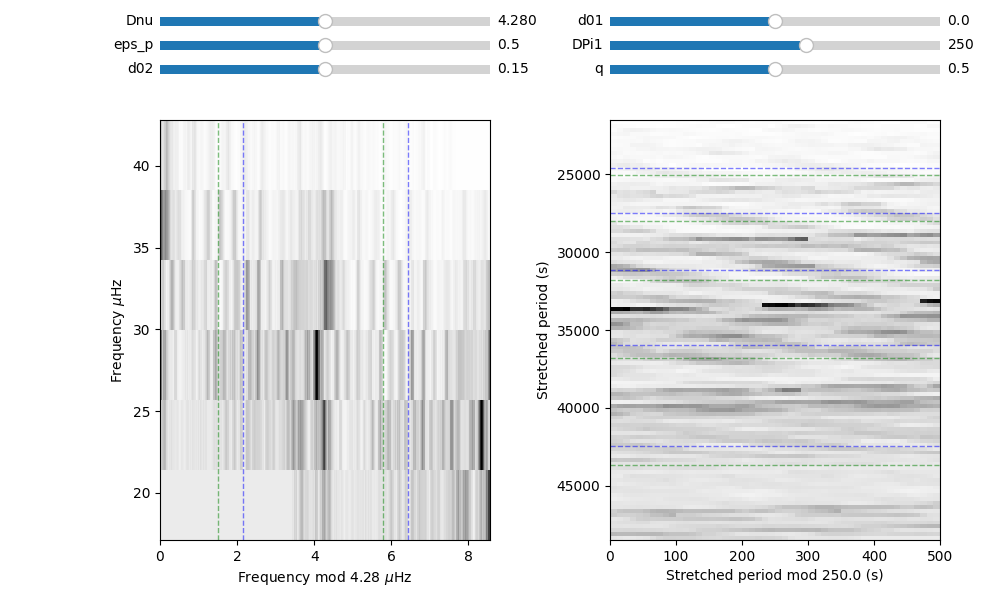

In [59]:
# resample spectrum to have 5000 pixels
nu = np.linspace(nu_max-2*delta_nu, nu_max+4*delta_nu, 5000)
ps = np.interp(nu, freq, smoothed_power)

# initiate a star object
star = Star(nu, ps, nu_max, delta_nu)

# interactive echelles
star.plot_freq_echelle()

<IPython.core.display.Javascript object>


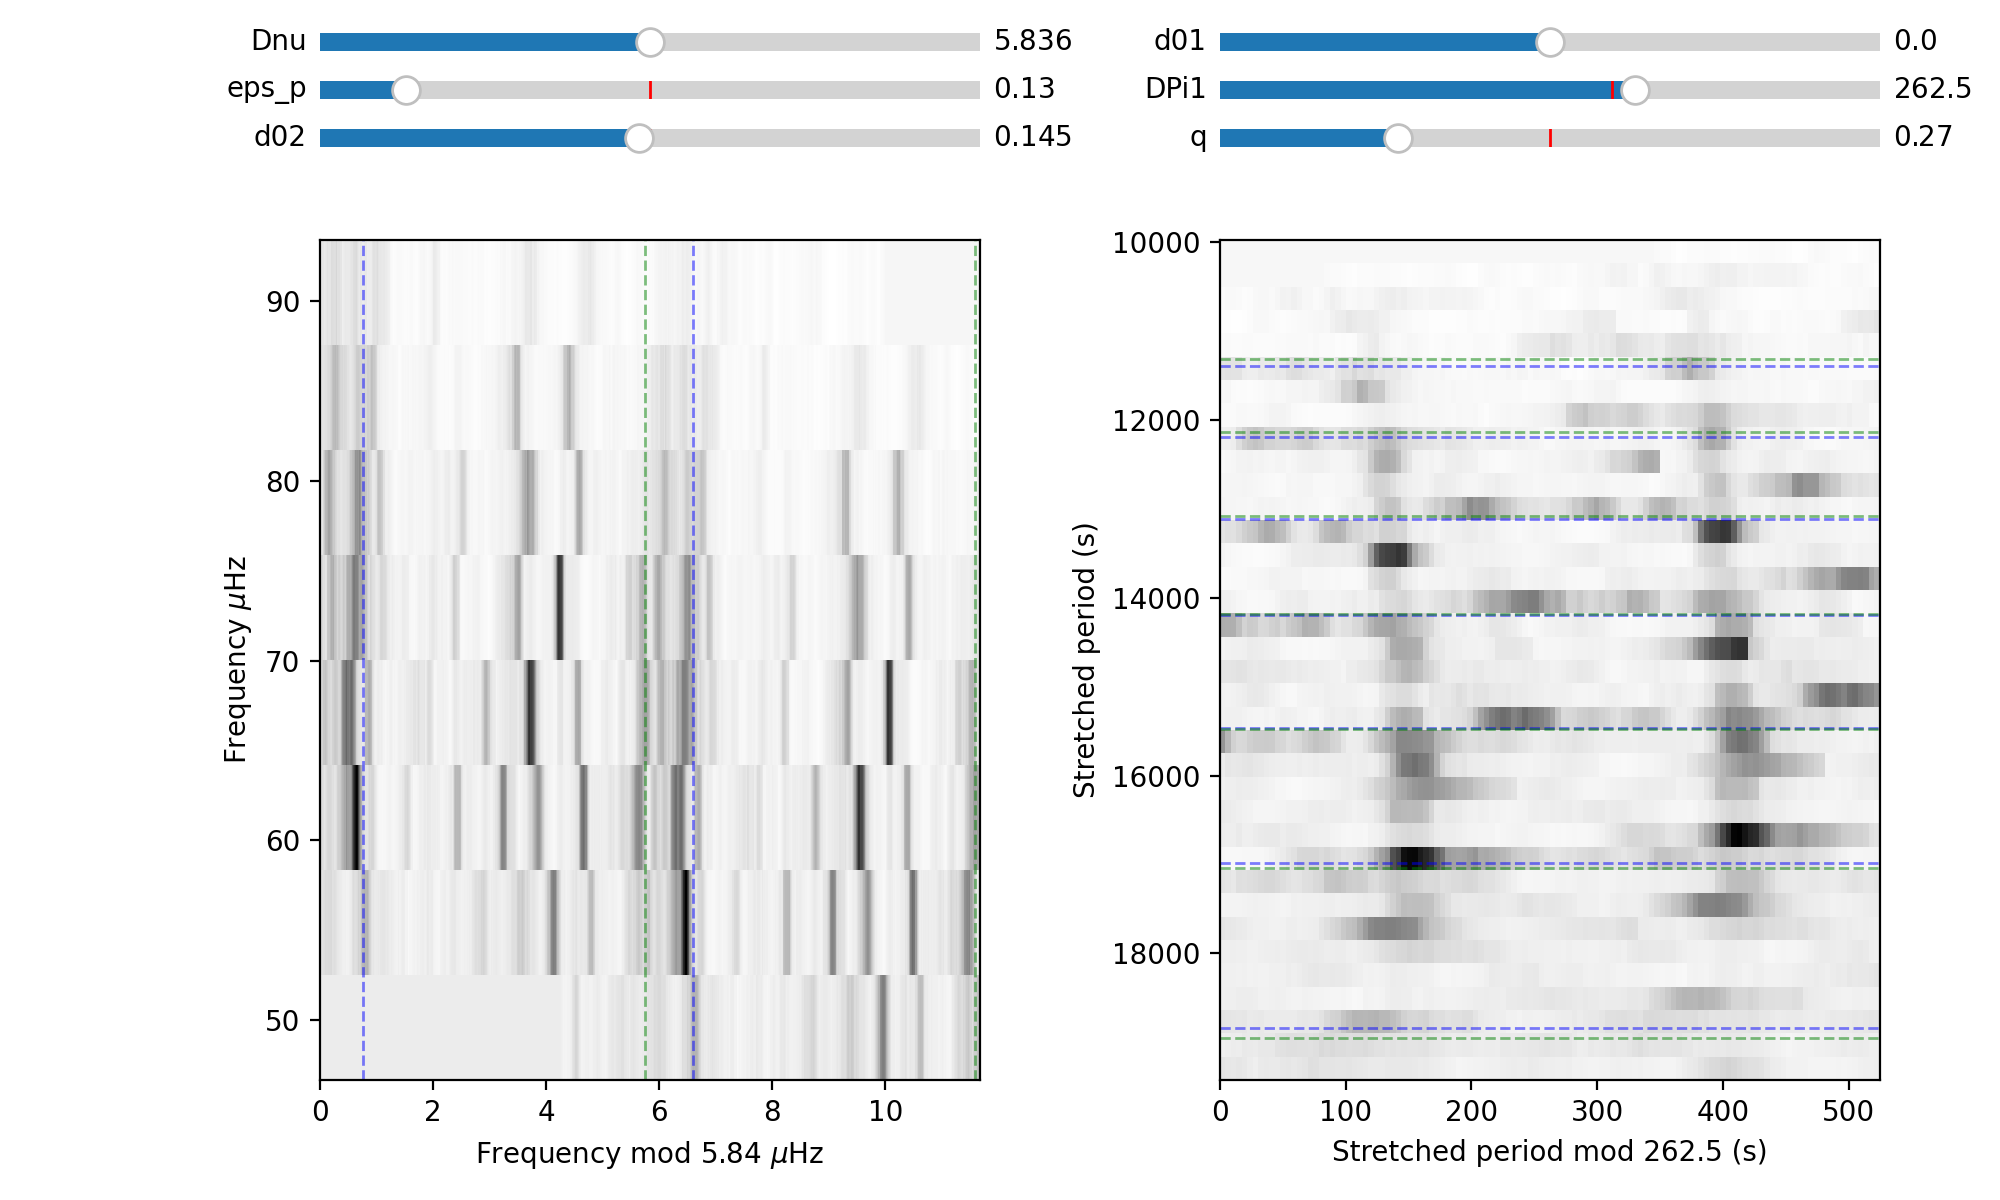

In [27]:
# resample spectrum to have 5000 pixels
nu = np.linspace(nu_max-4*delta_nu, nu_max+4*delta_nu, 5000)
ps = np.interp(nu, freq, smoothed_power)

# initiate a star object
star = Star(nu, ps, nu_max, delta_nu)

# interactive echelles
star.plot_freq_echelle()